# **Emotions and Loans Data Analysis**

### **We will be analying the data we cleaned and explored in SQL.**

Import the necessary applications

In [434]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


Now we load the csv files and look at the head of each data file. 

In [450]:
# Extract loan data
loan_data = pd.read_csv('../data_input/loan.csv')

# Extract emotional data
emotion_data = pd.read_csv('../data_input/emotional_data.csv')

# Extract user data
user_data = pd.read_csv('../data_input/users.csv')

In [340]:
# Loan data table
print('loan data')
loan_data.head()

loan data


,loan_id,user_id,loan_amount,total_amount,issue_date,due_date,paid_date,installment_amount,loan_amount_paid,status
0,1,1,29955,47928.00,2021-06-14,2022-06-09,2021-10-05,3994.00,35596.53,paid
1,2,1,15473,24756.80,2022-12-06,2023-12-01,2023-08-17,2063.07,22023.24,paid
2,3,1,15781,25249.60,2025-04-24,2026-04-19,2025-04-28,2104.13,15886.21,paid
3,4,3,8715,13421.10,2024-10-28,2025-04-26,NaN,2236.85,0.00,late
4,5,4,1721,2288.93,2021-03-09,2021-06-07,2021-03-29,762.98,1847.21,paid


In [341]:
# Emotion data table
print('emotion data')
emotion_data.head()

emotion data


,user_id,timestamp,intensity,time_of_day,primary_emotion,relationship,situation,location,weather,physical_state,preceding_event,grade
0,1,2019-04-07 03:16:21,7.0,night,shame,neighbor,in meeting,work,sunny,tired,NaN,2.94
1,1,2019-04-07 14:02:53,9.0,afternoon,boredom,parent,volunteering,home,snowy,NaN,good news,4.79
2,1,2019-04-07 22:50:39,4.0,night,anticipation,NaN,cooking,NaN,cloudy,energetic,criticism,3.72
3,1,2019-04-08 16:12:02,1.0,afternoon,joy,child,clothes shopping,NaN,sunny,NaN,surprise,2.97
4,1,2019-04-08 17:10:35,5.0,evening,joy,stranger,argument,NaN,windy,rested,compliment,5.35


In [342]:
# User data table
print('user data')
user_data.head()

user data


,user_id,score,approved_date,denied_date,credit_limit,interest_rate,loan_term
0,1,5.69,2020-05-21,NaN,32700.0,0.05,12.0
1,2,NaN,NaN,NaN,NaN,NaN,NaN
2,3,5.61,2023-12-04,2025-04-26,9500.0,0.09,6.0
3,4,5.64,2020-05-14,NaN,1800.0,0.11,3.0
4,5,5.64,2021-04-29,NaN,1700.0,0.11,3.0


We could merge our data for use later. 

In [343]:
# Merge emotion_data with loan_data on 'user_id'
merged_data = pd.merge(loan_data, user_data, on='user_id')

# Merge emotion and merged_data DataFrames on 'user_id'
merged_df = pd.merge(emotion_data, merged_data, on='user_id')

# Filter rows to only include emotions recorded between the issue_date and due_date of the corresponding loan
# Ensure the timestamp, issue_date, and due_date are in datetime format
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])
merged_df['issue_date'] = pd.to_datetime(merged_df['issue_date'])
merged_df['due_date'] = pd.to_datetime(merged_df['due_date'])

# Filter based on the condition that the emotion's timestamp is between the loan's issue_date and due_date
filtered_df = merged_df[(merged_df['timestamp'] >= merged_df['issue_date']) & 
                        (merged_df['timestamp'] <= merged_df['due_date'])]

filtered_df.head()
display(filtered_df)

,user_id,timestamp,intensity,time_of_day,primary_emotion,relationship,situation,location,weather,physical_state,...,paid_date,installment_amount,loan_amount_paid,status,score,approved_date,denied_date,credit_limit,interest_rate,loan_term
3732,1,2021-06-14 12:24:01,5.0,afternoon,fear,neighbor,NaN,public space,cold,rested,...,2021-10-05,3994.00,35596.53,paid,5.69,2020-05-21,NaN,32700.0,0.05,12.0
3735,1,2021-06-14 14:35:55,8.0,afternoon,surprise,subordinate,NaN,hospital,NaN,rested,...,2021-10-05,3994.00,35596.53,paid,5.69,2020-05-21,NaN,32700.0,0.05,12.0
3738,1,2021-06-16 01:35:04,1.0,night,amusement,subordinate,NaN,home,snowy,NaN,...,2021-10-05,3994.00,35596.53,paid,5.69,2020-05-21,NaN,32700.0,0.05,12.0
3741,1,2021-06-16 15:26:34,8.0,afternoon,sadness,child,job interview,work,snowy,rested,...,2021-10-05,3994.00,35596.53,paid,5.69,2020-05-21,NaN,32700.0,0.05,12.0
3744,1,2021-06-17 02:03:00,8.0,night,surprise,ex-partner,job interview,NaN,cloudy,rested,...,2021-10-05,3994.00,35596.53,paid,5.69,2020-05-21,NaN,32700.0,0.05,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3949281,734,2025-04-29 05:53:45,6.0,morning,love,teacher,family gathering,work,sunny,sick,...,2025-04-28,364.65,1371.16,paid,5.64,2021-03-10,NaN,1400.0,0.11,6.0
3949284,734,2025-04-29 16:09:18,4.0,afternoon,amusement,close friend,doctors appointment,public space,snowy,rested,...,2025-04-28,364.65,1371.16,paid,5.64,2021-03-10,NaN,1400.0,0.11,6.0
3949287,734,2025-05-01 04:12:43,9.0,night,sadness,subordinate,reading,NaN,rainy,injured,...,2025-04-28,364.65,1371.16,paid,5.64,2021-03-10,NaN,1400.0,0.11,6.0
3949290,734,2025-05-01 07:31:12,2.0,morning,pride,student,NaN,work,cloudy,exited,...,2025-04-28,364.65,1371.16,paid,5.64,2021-03-10,NaN,1400.0,0.11,6.0


## **Emotional Pattern Analysis**

To explore the emotional patterns, we first explore the daata using descriptive statistics like .describe. 

In [344]:
# Descriptive statistics
display(emotion_data.describe())

,user_id,intensity,grade
count,2.440931e+06,2.440931e+06,2.440931e+06
mean,3.674154e+02,5.499647e+00,4.595633e+00
std,2.118994e+02,2.871508e+00,1.855770e+00
min,1.000000e+00,1.000000e+00,8.300000e-01
25%,1.840000e+02,3.000000e+00,3.040000e+00
50%,3.670000e+02,5.000000e+00,4.190000e+00
75%,5.510000e+02,8.000000e+00,6.020000e+00
max,7.340000e+02,1.000000e+01,1.000000e+01


Here, we learned things like the mean intensity of users!

#### **We now explore and identify dominant emotional patterns for users over time.**

Let's double check and preprocess the data. Here, we are making sure that the data is clean and ready for analysis by converting timestamps to datetime objects for easier manipulation. 

In [345]:
# Convert timestamps to datetime
emotion_data['timestamp'] = pd.to_datetime(emotion_data['timestamp'], errors='coerce')

# Check for missing values and handle them as necessary
print(emotion_data.isnull().sum())


user_id                 0
timestamp               0
intensity               0
time_of_day             0
primary_emotion         0
relationship       561364
situation          560778
location           560019
weather            559957
physical_state     562253
preceding_event    561929
grade                   0
dtype: int64


Now we identify the dominant emotional patterns for users over time.

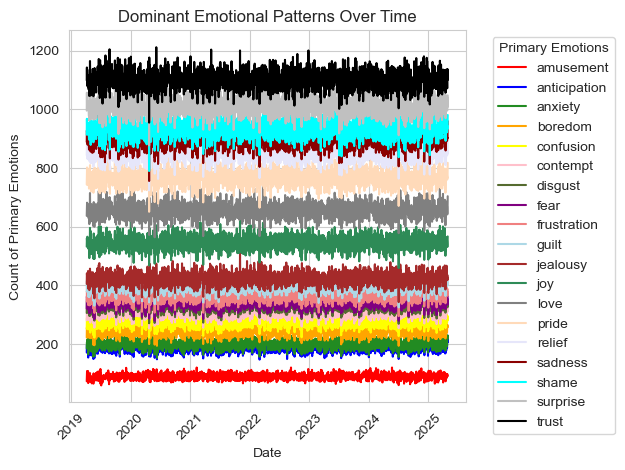

In [346]:
# Extract date for analysis
emotion_data['date'] = emotion_data['timestamp'].dt.date

# Step 1: Identify dominant emotional patterns over time
dominant_emotions = emotion_data.groupby(['date', 'primary_emotion']).size().unstack(fill_value=0)

# Define a custom color palette with specified colors
custom_palette = [
    'red',       
    'blue',       
    'forestgreen',  
    'orange',     
    'yellow',      
    'pink',        
    'darkolivegreen', 
    'purple',        
    'lightcoral',    
    'lightblue',     
    'brown',        
    'seagreen',      
    'gray',         
    '#FFDAB9',        
    '#E6E6FA',        
    'darkred',       
    'cyan',
    'silver',
    'black'

]

# Set the custom palette
sns.set_palette(custom_palette)

# Plotting the dominant emotional patterns over time
dominant_emotions.plot(kind='line', stacked=True)
plt.title("Dominant Emotional Patterns Over Time")
plt.ylabel("Count of Primary Emotions")
plt.xlabel("Date")
plt.legend(title='Primary Emotions', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Here, we see that the most dominant emotion is trust overtime as the count for it is around 1200 from 2020-2024 and the least dominant emotion is amusement as it is at the bottom of the graph. 

#### **Next, we analyze how emotions correlate with different contexts.**

To analyze how emotional patterns differ based on various contexts, we group by context then the emotion. We use plot_emotions_by_category to calculate the total counts for each context. 

In [347]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_emotions_by_category(data, category, emotions, title, xlabel, ylabel):
    """
    Function to plot the proportion of emotions by category (e.g., relationship, situation).
    """
    # Create a pivot table that counts each emotion occurrence by category (e.g., relationship, situation)
    emotion_counts = data.pivot_table(index=category, columns=emotions, aggfunc='size', fill_value=0)

    # Normalize by dividing each count by the row total to get proportions
    emotion_proportions = emotion_counts.div(emotion_counts.sum(axis=1), axis=0)

    # Plot the horizontal stacked bar chart
    ax = emotion_proportions.plot(kind='barh', stacked=True, figsize=(12, 6), colormap='Set3')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title='Primary Emotions', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Display the summary DataFrame
    summary_df = emotion_counts.copy()
    summary_df['Total Count'] = summary_df.sum(axis=1)  # Total counts for each context
    summary_df.reset_index(inplace=True)
    
    # Display the counts and proportions together
    proportions_df = emotion_proportions.copy()
    proportions_df['Total Count'] = summary_df['Total Count']
    print(proportions_df)



Let us analyze emotions by relationships!

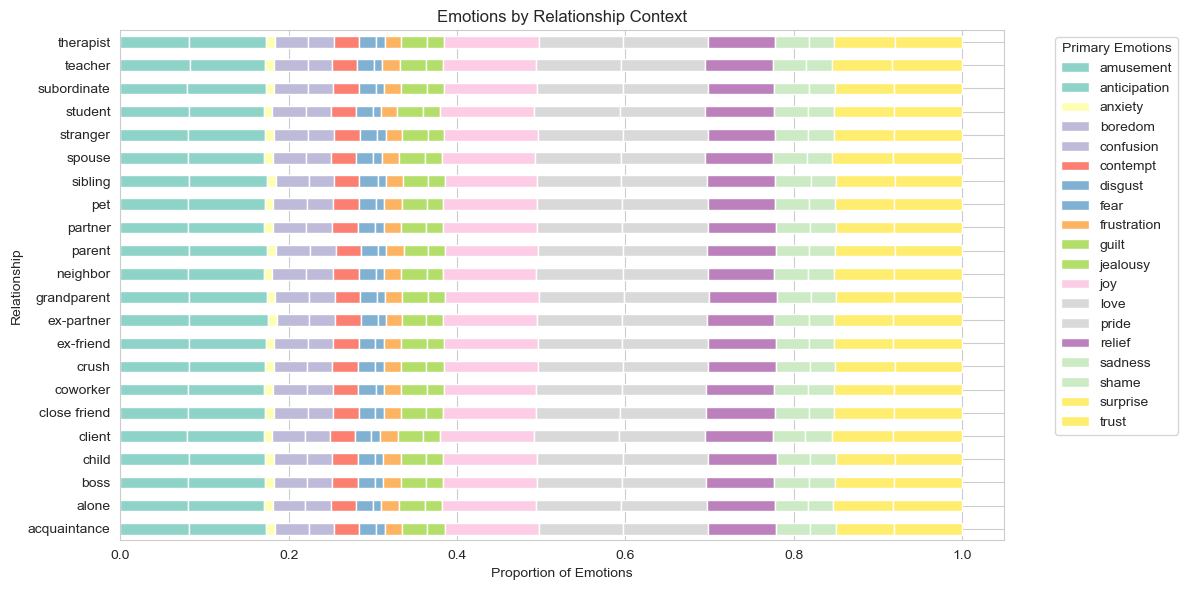

primary_emotion  amusement  anticipation   anxiety   boredom  confusion  \
relationship                                                              
acquaintance      0.081269      0.091703  0.010492  0.040245   0.030225   
alone             0.080800      0.089905  0.010333  0.038737   0.029929   
boss              0.079699      0.092258  0.010042  0.039658   0.030292   
child             0.081489      0.090842  0.009767  0.039491   0.029876   
client            0.079502      0.091456  0.009689  0.038715   0.030121   
close friend      0.080734      0.091605  0.010308  0.040507   0.029473   
coworker          0.080865      0.090107  0.010166  0.040309   0.030637   
crush             0.081226      0.090828  0.010507  0.039458   0.028977   
ex-friend         0.080937      0.091685  0.010187  0.040188   0.029735   
ex-partner        0.081410      0.093451  0.010923  0.038504   0.030746   
grandparent       0.081425      0.092816  0.009958  0.039798   0.030493   
neighbor          0.07988

In [348]:
# Analyze emotions by 'relationship' category
plot_emotions_by_category(emotion_data, 'relationship', 'primary_emotion', 'Emotions by Relationship Context', 'Proportion of Emotions', 'Relationship')

Here we can see that the emotions do not correlate dramatically with relationship, as the heights of the bars are quite similar across different relationships. This indicates a relatively uniform distribution of emotions, suggesting that the context of relationship may not significantly influence emotional responses.

We can also see what is the most common emotion for each relationship. 

In [409]:
# Group by 'time_of_day' and 'primary_emotion', and count occurrences
emotions_by_relationship = emotion_data.groupby(['relationship', 'primary_emotion']).size().reset_index(name='relationship_count')

# Get the most frequent emotion for each time of day
most_frequent_emotions = emotions_by_relationship.loc[emotions_by_relationship.groupby('relationship')['relationship_count'].idxmax()]

# Display the most frequent emotion for each time of day
print(most_frequent_emotions)

     relationship primary_emotion  relationship_count
11   acquaintance             joy                9421
30          alone             joy                5653
49           boss             joy               11379
68          child             joy               13207
87         client             joy                2857
106  close friend             joy               12108
125      coworker             joy               10251
144         crush             joy                8570
163     ex-friend             joy                3793
182    ex-partner             joy                4673
201   grandparent             joy               10445
220      neighbor             joy                8402
239        parent             joy               12174
258       partner             joy               14215
277           pet             joy               10381
296       sibling             joy               11110
315        spouse             joy               13170
334      stranger           

Joy is the most common feeling for every relationship!

Now we can look at emotions by situation. 

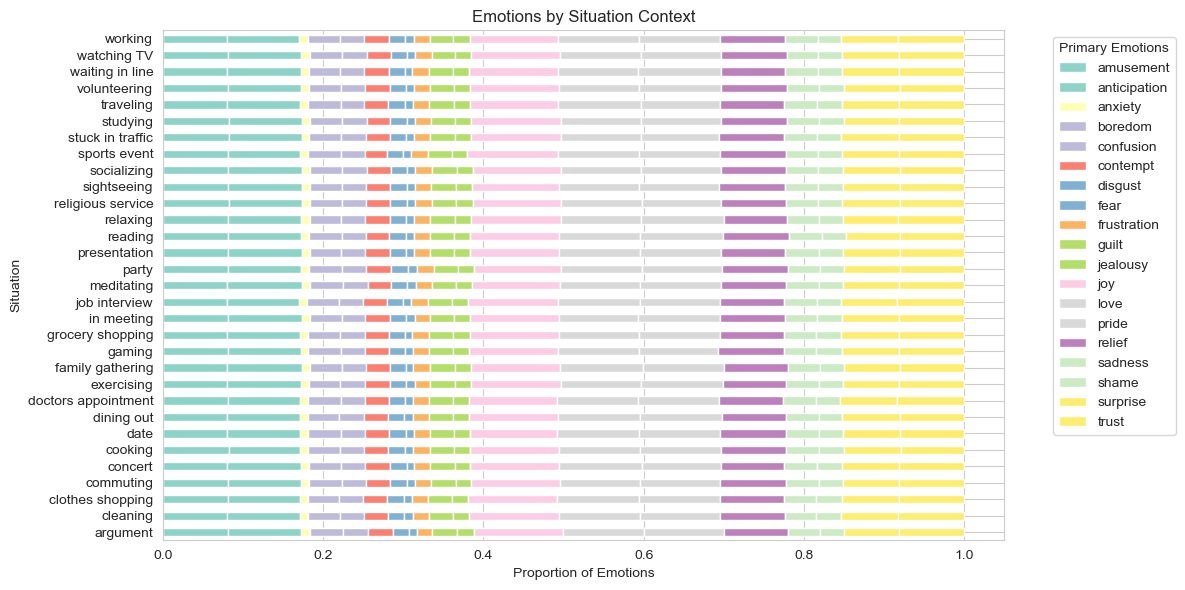

primary_emotion      amusement  anticipation   anxiety   boredom  confusion  \
situation                                                                     
argument              0.080502      0.092189  0.010188  0.041975   0.031287   
cleaning              0.080039      0.091177  0.010225  0.039204   0.029974   
clothes shopping      0.080642      0.090209  0.009904  0.038791   0.030014   
commuting             0.080597      0.091657  0.010573  0.040217   0.029952   
concert               0.080234      0.091610  0.010050  0.040581   0.029437   
cooking               0.081909      0.089092  0.009928  0.039857   0.029751   
date                  0.079317      0.091827  0.010100  0.040352   0.030598   
dining out            0.080076      0.090362  0.010351  0.038508   0.031168   
doctors appointment   0.080506      0.090352  0.010504  0.041005   0.029740   
exercising            0.080033      0.091607  0.010091  0.039815   0.030321   
family gathering      0.080256      0.093627  0.0101

In [349]:
# Analyze emotions by 'situation' category
plot_emotions_by_category(emotion_data, 'situation', 'primary_emotion', 'Emotions by Situation Context', 'Proportion of Emotions', 'Situation')

Here we can see that the emotions do not correlate dramatically with situation, as the heights of the bars are quite similar across different situations. This indicates a relatively uniform distribution of emotions, suggesting that the context of situation may not significantly influence emotional responses.

We can also see the most common emotion based on situation. 

In [415]:
# Group by 'situation' and 'primary_emotion', and count occurrences
emotions_by_situation = emotion_data.groupby(['situation', 'primary_emotion']).size().reset_index(name='situation_count')

# Get the most frequent emotion for situation
most_frequent_emotions = emotions_by_situation.loc[emotions_by_situation.groupby('situation')['situation_count'].idxmax()]

# Display the most frequent emotion for situation
print(most_frequent_emotions)

               situation primary_emotion  situation_count
11              argument             joy             6482
30              cleaning             joy             6860
49      clothes shopping             joy             6615
68             commuting             joy             6825
87               concert             joy             6685
106              cooking             joy             6880
125                 date             joy             6633
144           dining out             joy             6732
163  doctors appointment             joy             6505
182           exercising             joy             6970
201     family gathering             joy             6872
220               gaming             joy             6434
239     grocery shopping             joy             6687
258           in meeting             joy             6883
277        job interview             joy             6782
296           meditating             joy             6720
315           

Joy is the most common emotion based on all types of situations.

We can analyze emotions based on time of day!

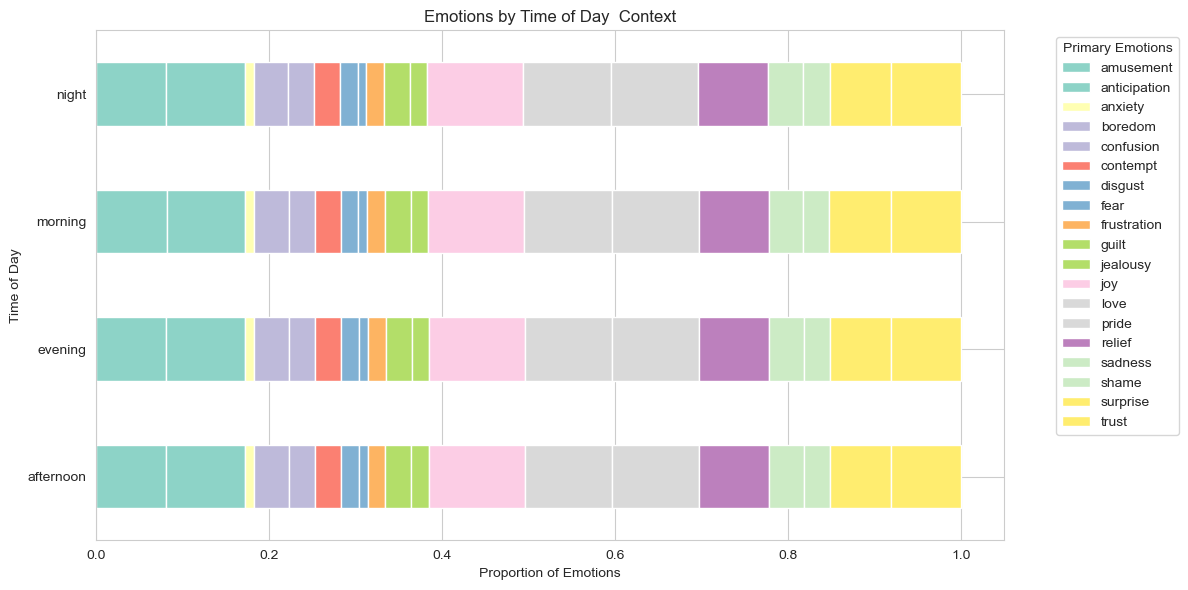

primary_emotion  amusement  anticipation   anxiety   boredom  confusion  \
time_of_day                                                               
afternoon         0.080614      0.091529  0.010255  0.040408   0.030010   
evening           0.080397      0.091773  0.010135  0.040184   0.030221   
morning           0.081316      0.091097  0.009971  0.039967   0.030176   
night             0.080989      0.090977  0.009977  0.040075   0.030149   

primary_emotion  contempt   disgust      fear  frustration     guilt  \
time_of_day                                                            
afternoon        0.030618  0.020148  0.010208     0.020250  0.030234   
evening          0.030602  0.020543  0.010339     0.020364  0.030506   
morning          0.030313  0.020433  0.010019     0.020565  0.030093   
night            0.030158  0.020106  0.009992     0.020087  0.029999   

primary_emotion  jealousy       joy      love     pride    relief   sadness  \
time_of_day                          

In [350]:
# Analyze emotions by 'time_of_day' category
plot_emotions_by_category(emotion_data, 'time_of_day', 'primary_emotion', 'Emotions by Time of Day Context', 'Proportion of Emotions', 'Time of Day')

Here we can see that the emotions do not correlate dramatically with time of day, as the heights of the bars are quite similar across different time of day. This indicates a relatively uniform distribution of emotions, suggesting that the context of time of day may not significantly influence emotional responses.

We can check the most frequent emotion for each time of day. 

In [406]:
# Group by 'time_of_day' and 'primary_emotion', and count occurrences
emotions_by_time_of_day = emotion_data.groupby(['time_of_day', 'primary_emotion']).size().reset_index(name='emotion_count')

# Get the most frequent emotion for each time of day
most_frequent_emotions = emotions_by_time_of_day.loc[emotions_by_time_of_day.groupby('time_of_day')['emotion_count'].idxmax()]

# Display the most frequent emotion for each time of day
print(most_frequent_emotions)


   time_of_day primary_emotion  emotion_count
11   afternoon             joy          56338
30     evening             joy          45042
49     morning             joy          79383
68       night             joy          90572


Joy is the most frequent emotion for all times of day!

Next, we can analyze emotions based on location. 

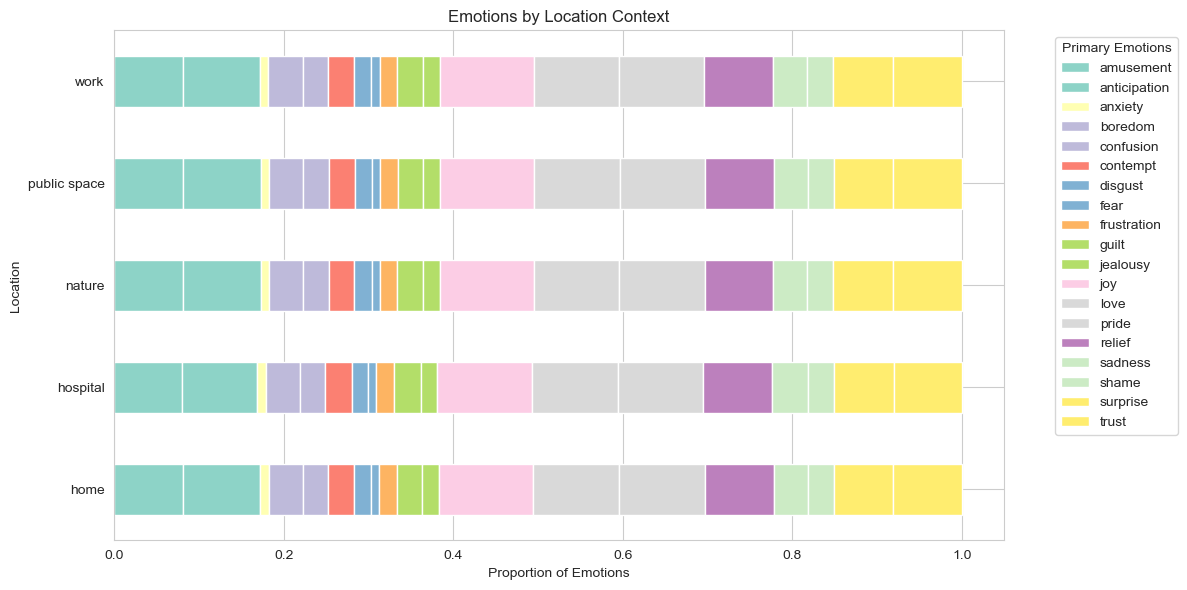

primary_emotion  amusement  anticipation   anxiety   boredom  confusion  \
location                                                                  
home              0.081261      0.091170  0.009897  0.040238   0.029977   
hospital          0.079927      0.088857  0.009978  0.040540   0.029636   
nature            0.080829      0.091766  0.010256  0.039945   0.030295   
public space      0.081256      0.091669  0.010014  0.039991   0.030205   
work              0.080745      0.091215  0.009904  0.040459   0.030179   

primary_emotion  contempt   disgust      fear  frustration     guilt  \
location                                                               
home             0.030093  0.020286  0.009946     0.020276  0.030090   
hospital         0.031244  0.019396  0.009628     0.021196  0.030964   
nature           0.030297  0.020435  0.009928     0.020145  0.030106   
public space     0.030599  0.020115  0.010269     0.020353  0.029713   
work             0.030112  0.020391  0.010

In [416]:
# Analyze emotions by 'location' category
plot_emotions_by_category(emotion_data, 'location', 'primary_emotion', 'Emotions by Location Context', 'Proportion of Emotions', 'Location')

Here we can see that the emotions do not correlate dramatically with location, as the heights of the bars are quite similar across different locations. This indicates a relatively uniform distribution of emotions, suggesting that the context of location may not significantly influence emotional responses.

We could also look at the most common emotion based on location.

In [417]:
# Group by 'location' and 'primary_emotion', and count occurrences
emotions_by_location = emotion_data.groupby(['location', 'primary_emotion']).size().reset_index(name='location_count')

# Get the most frequent emotion for location
most_frequent_emotions = emotions_by_location.loc[emotions_by_location.groupby('location')['location_count'].idxmax()]

# Display the most frequent emotion for situation
print(most_frequent_emotions)

        location primary_emotion  location_count
11          home             joy           57036
30      hospital             joy            6414
49        nature             joy           57030
68  public space             joy           57033
87          work             joy           31466


Joy is the most common emotion for each location!

Let us analyze emotion based on weather. 

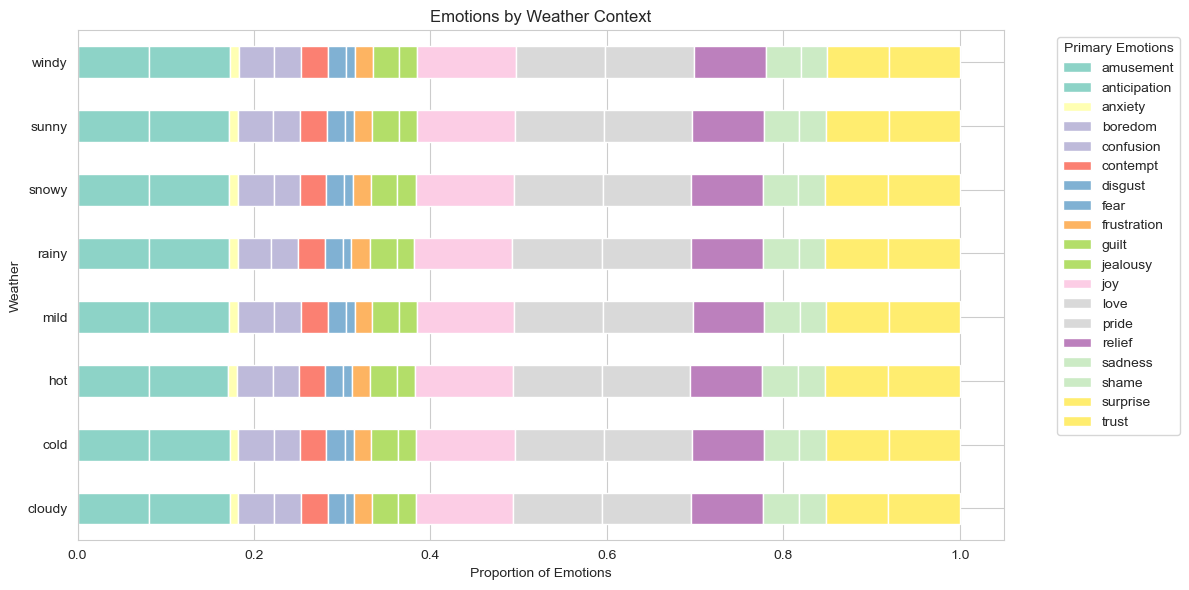

primary_emotion  amusement  anticipation   anxiety   boredom  confusion  \
weather                                                                   
cloudy            0.081397      0.090874  0.010054  0.040492   0.030791   
cold              0.081122      0.091419  0.009820  0.039739   0.030077   
hot               0.080532      0.090312  0.009843  0.040406   0.029696   
mild              0.080962      0.091132  0.010186  0.040865   0.030433   
rainy             0.080639      0.091173  0.009693  0.038148   0.030034   
snowy             0.080643      0.091225  0.010376  0.040022   0.029869   
sunny             0.080867      0.090917  0.009975  0.040310   0.030493   
windy             0.081396      0.091812  0.010118  0.039755   0.030417   

primary_emotion  contempt   disgust      fear  frustration     guilt  \
weather                                                                
cloudy           0.029899  0.019591  0.009957     0.020151  0.029874   
cold             0.029940  0.0207

In [352]:
# Analyze emotions by 'weather' category
plot_emotions_by_category(emotion_data, 'weather', 'primary_emotion', 'Emotions by Weather Context', 'Proportion of Emotions', 'Weather')

Here we can see that the emotions do not correlate dramatically with weather, as the heights of the bars are quite similar across different weather. This indicates a relatively uniform distribution of emotions, suggesting that the context of weather may not significantly influence emotional responses.

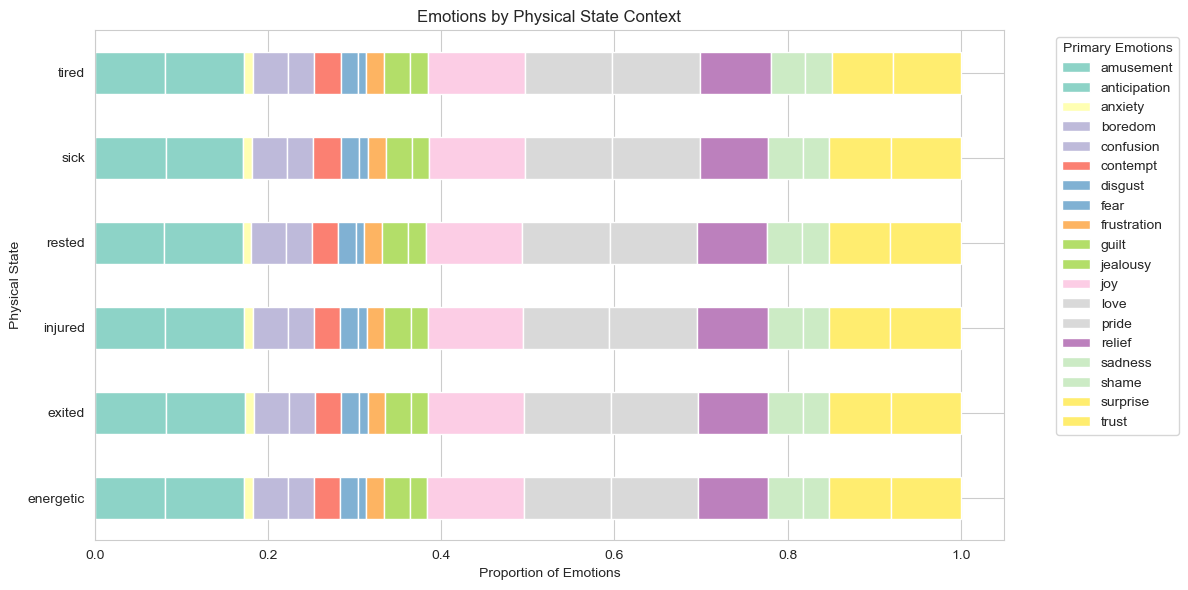

primary_emotion  amusement  anticipation   anxiety   boredom  confusion  \
physical_state                                                            
energetic         0.080769      0.091692  0.010157  0.039933   0.030379   
exited            0.081734      0.091996  0.009721  0.040116   0.030501   
injured           0.081365      0.090541  0.010474  0.040460   0.029861   
rested            0.079893      0.090965  0.009961  0.040171   0.029930   
sick              0.082335      0.088658  0.010764  0.039608   0.031028   
tired             0.081074      0.091406  0.010190  0.040838   0.029724   

primary_emotion  contempt   disgust      fear  frustration     guilt  \
physical_state                                                         
energetic        0.030268  0.020263  0.009878     0.020306  0.030271   
exited           0.030323  0.020358  0.010129     0.020039  0.030163   
injured          0.030503  0.020426  0.010177     0.020594  0.030177   
rested           0.030113  0.020028  0.

In [353]:
# Analyze emotions by 'physical_state' category
plot_emotions_by_category(emotion_data, 'physical_state', 'primary_emotion', 'Emotions by Physical State Context', 'Proportion of Emotions', 'Physical State')


Here we can see that the emotions do not correlate dramatically with physical state, as the heights of the bars are quite similar across different physical staates. This indicates a relatively uniform distribution of emotions, suggesting that the context of physical states may not significantly influence emotional responses.

Let us find the most common emotion based on physical state.

In [418]:
# Group by 'physical_state' and 'primary_emotion', and count occurrences
emotions_by_physical_state = emotion_data.groupby(['physical_state', 'primary_emotion']).size().reset_index(name='physical_state_count')

# Get the most frequent emotion for physical_state
most_frequent_emotions = emotions_by_physical_state.loc[emotions_by_physical_state.groupby('physical_state')['physical_state_count'].idxmax()]

# Display the most frequent emotion for situation
print(most_frequent_emotions)

    physical_state primary_emotion  physical_state_count
11       energetic             joy                 54395
30          exited             joy                 46275
49         injured             joy                 22823
68          rested             joy                 61840
87            sick             joy                  7722
106          tired             joy                 15604


Joy is the most common emotion based on different types of physical state!

Let us analyze emotions based on preceding event!

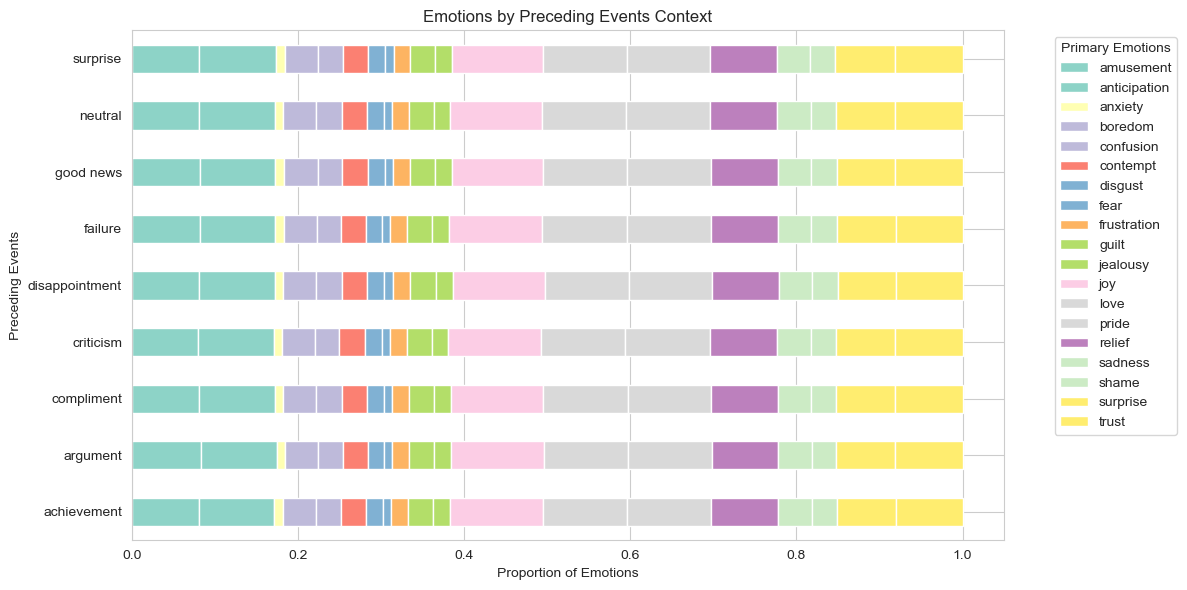

primary_emotion  amusement  anticipation   anxiety   boredom  confusion  \
preceding_event                                                           
achievement       0.080363      0.091175  0.009869  0.040030   0.030291   
argument          0.083699      0.090481  0.010071  0.040125   0.029574   
compliment        0.080925      0.090992  0.010018  0.040265   0.030234   
criticism         0.080207      0.090731  0.009770  0.039778   0.029243   
disappointment    0.081254      0.090586  0.010084  0.039960   0.030629   
failure           0.081723      0.090762  0.010162  0.040203   0.029124   
good news         0.081662      0.090997  0.010183  0.040701   0.030046   
neutral           0.080420      0.091724  0.009845  0.039759   0.030958   
surprise          0.081214      0.092459  0.010439  0.039999   0.029541   

primary_emotion  contempt   disgust      fear  frustration     guilt  \
preceding_event                                                        
achievement      0.030283  0.0

In [354]:
# Analyze emotions by 'preceding_event' category
plot_emotions_by_category(emotion_data, 'preceding_event', 'primary_emotion', 'Emotions by Preceding Events Context', 'Proportion of Emotions', 'Preceding Events')

Here we can see that the emotions do not correlate dramatically with preceding event, as the heights of the bars are quite similar across different preceding event. This indicates a relatively uniform distribution of emotions, suggesting that the context of preceding event may not significantly influence emotional responses.

We could also look at the most common emotion based on different types of preceding events!

In [420]:
# Group by 'preceding_event' and 'primary_emotion', and count occurrences
emotions_by_preceding_event = emotion_data.groupby(['preceding_event', 'primary_emotion']).size().reset_index(name='preceding_event_count')

# Get the most frequent emotion for preceding_event
most_frequent_emotions = emotions_by_preceding_event.loc[emotions_by_preceding_event.groupby('preceding_event')['preceding_event_count'].idxmax()]

# Display the most frequent emotion for preceding_event
print(most_frequent_emotions)

    preceding_event primary_emotion  preceding_event_count
11      achievement             joy                  43898
30         argument             joy                   4933
49       compliment             joy                  33942
68        criticism             joy                   9786
87   disappointment             joy                   9767
106         failure             joy                   9780
125       good news             joy                  43396
144         neutral             joy                  24210
163        surprise             joy                  28933


Here we can see that the most common emotion for each preceding event is joy!

We can also analyze the primary emotions when the user is alone vs with others.

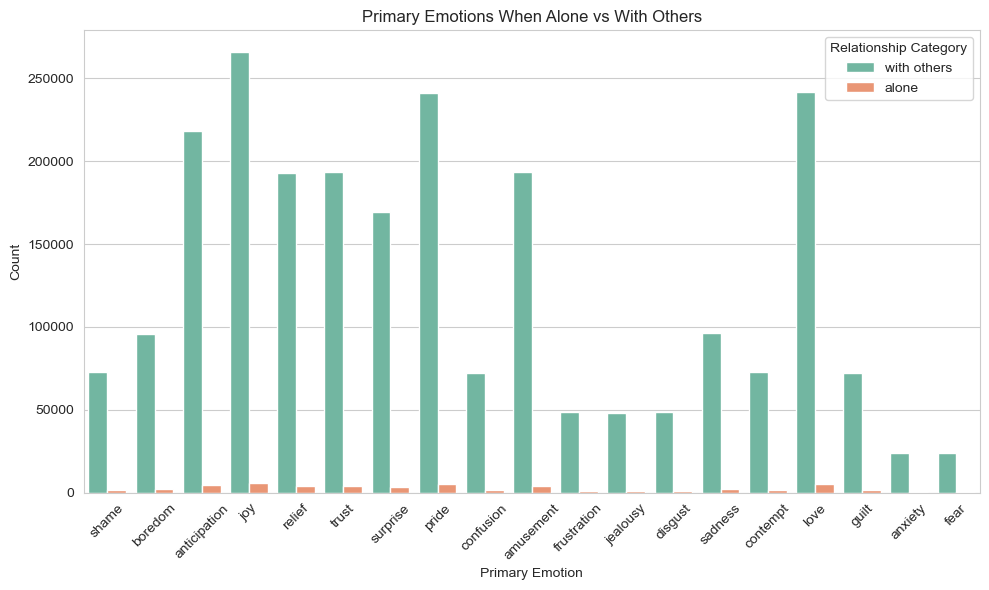

In [355]:
# Categorizing 'relationship' into 'alone' vs 'with others'
emotion_data['relationship_category'] = emotion_data['relationship'].apply(lambda x: 'alone' if x == 'alone' else 'with others')

# Plotting the primary emotions when alone vs with others
plt.figure(figsize=(10, 6))

# Create a count plot showing primary emotions for 'alone' vs 'with others'
sns.countplot(data=emotion_data, x='primary_emotion', hue='relationship_category', palette='Set2')

# Customize the plot
plt.title('Primary Emotions When Alone vs With Others')
plt.xlabel('Primary Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Relationship Category')

# Display the plot
plt.tight_layout()
plt.show()

This plot counts the emotions, but we want to standardize the data so we can see if the users tend to feel an emotion more when alone vs with others.

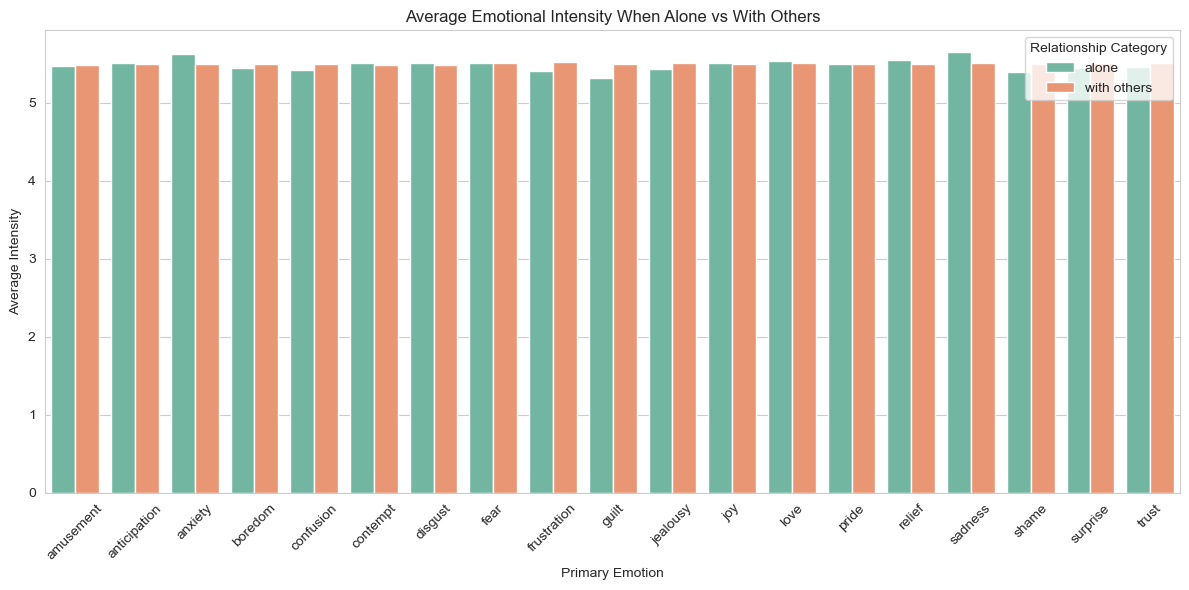

In [356]:
# Categorizing 'relationship' into 'alone' vs 'with others'
emotion_data['relationship_category'] = emotion_data['relationship'].apply(lambda x: 'alone' if x == 'alone' else 'with others')

# Group by relationship category and primary emotion, then calculate the average intensity
emotion_intensity = emotion_data.groupby(['relationship_category', 'primary_emotion']).agg({'intensity': 'mean'}).reset_index()

# Plotting the average emotional intensity when alone vs with others
plt.figure(figsize=(12, 6))

# Create a bar plot to show average intensity
sns.barplot(data=emotion_intensity, x='primary_emotion', y='intensity', hue='relationship_category', palette='Set2')

# Customize the plot
plt.title('Average Emotional Intensity When Alone vs With Others')
plt.xlabel('Primary Emotion')
plt.ylabel('Average Intensity')
plt.xticks(rotation=45)
plt.legend(title='Relationship Category')

# Display the plot
plt.tight_layout()
plt.show()

Now we see that the emotions are quite equivalent when alone or with others. 

Note that the nulls we had in relationship column stayed as nulls in this analysis. Meaning if the nulls were meant to be counted as alone, they were not as we cannot assume that null means alone. 

We can also analyze the most common emotions for users during loans, overall, and not during loans. 

In [360]:
# Define a function to get the ranked emotions for each DataFrame
def get_emotion_ranking(df, df_name):
    emotion_counts = df['primary_emotion'].value_counts()
    total_emotions = df['primary_emotion'].count()
    
    # Create a DataFrame with the emotion rankings and percentage
    emotion_ranking_df = pd.DataFrame({
        'Emotion': emotion_counts.index,
        'Count': emotion_counts.values,
        'Percentage': (emotion_counts.values / total_emotions) * 100
    })
    
    emotion_ranking_df['Percentage'] = emotion_ranking_df['Percentage'].map(lambda x: f"{x:.2f}%")
    emotion_ranking_df['DataFrame'] = df_name
    
    return emotion_ranking_df

# Get the ranking of emotions for the entire emotion_data
emotion_ranking_all = get_emotion_ranking(emotion_data, 'All Data')

# Get the ranking of emotions for the filtered data
emotion_ranking_filtered = get_emotion_ranking(filtered_df, 'Filtered Data')

# Correct non-filtered data by identifying the rows in emotion_data that are not in filtered_df
non_filtered_emotion_df = emotion_data.merge(filtered_df[['user_id', 'timestamp']], 
                                             on=['user_id', 'timestamp'], 
                                             how='left', 
                                             indicator=True)

# Select only rows that are in emotion_data but not in filtered_df (i.e., `_merge == 'left_only'`)
non_filtered_emotion_df = non_filtered_emotion_df[non_filtered_emotion_df['_merge'] == 'left_only'].drop(columns=['_merge'])

# Now we can get the ranking of emotions for the non-filtered data
emotion_ranking_non_filtered = get_emotion_ranking(non_filtered_emotion_df, 'Non-Filtered Data')

# Optionally, print the results if needed
print("All Data Emotion Rankings:\n") 
display(emotion_ranking_all)
print("Filtered Data Emotion Rankings:\n")
display(emotion_ranking_filtered)
print("Non-Filtered Data Emotion Rankings:\n")
display(emotion_ranking_non_filtered)

All Data Emotion Rankings:



,Emotion,Count,Percentage,DataFrame
0,joy,271335,11.12%,All Data
1,love,246686,10.11%,All Data
2,pride,246081,10.08%,All Data
3,anticipation,222758,9.13%,All Data
4,amusement,197490,8.09%,All Data
5,trust,197351,8.09%,All Data
6,relief,197308,8.08%,All Data
7,surprise,172784,7.08%,All Data
8,sadness,98560,4.04%,All Data
9,boredom,97957,4.01%,All Data


Filtered Data Emotion Rankings:



,Emotion,Count,Percentage,DataFrame
0,joy,46682,11.13%,Filtered Data
1,love,42180,10.06%,Filtered Data
2,pride,42173,10.06%,Filtered Data
3,anticipation,38409,9.16%,Filtered Data
4,amusement,33967,8.10%,Filtered Data
5,trust,33867,8.08%,Filtered Data
6,relief,33787,8.06%,Filtered Data
7,surprise,29501,7.03%,Filtered Data
8,boredom,16938,4.04%,Filtered Data
9,sadness,16902,4.03%,Filtered Data


Non-Filtered Data Emotion Rankings:



,Emotion,Count,Percentage,DataFrame
0,joy,224653,11.11%,Non-Filtered Data
1,love,204506,10.12%,Non-Filtered Data
2,pride,203908,10.09%,Non-Filtered Data
3,anticipation,184349,9.12%,Non-Filtered Data
4,amusement,163523,8.09%,Non-Filtered Data
5,relief,163521,8.09%,Non-Filtered Data
6,trust,163484,8.09%,Non-Filtered Data
7,surprise,143283,7.09%,Non-Filtered Data
8,sadness,81658,4.04%,Non-Filtered Data
9,boredom,81019,4.01%,Non-Filtered Data


Here we learn that users feel joy the most in all three aspects. 

After analyzing the emotional patterns, we can conclude that the dominant emotions for users overtime is trust and there is no strong evidence to show that emotions correlate with different contexts. 

#### **To refine the emotional data collection process:**

Standardized emotional metrics:
* A key starting point is the establishment of standardized emotional metrics. By defining clear and consistent metrics for emotional categories, such as intensity and primary emotion, organizations can ensure that data collection is uniform. Additionally, using established scales—such as the Positive and Negative Affect Schedule—can provide a reliable framework for measuring emotional states.

Data quality improvement with tools:
* To improve data quality we can use structured data collection tools. Well-designed surveys and questionnaires, incorporating Likert scales for measuring intensity and closeness, can provide quantitative data on emotional states. Moreover, leveraging digital tools, like mobile apps or web-based platforms, can enable real-time emotional logging, reducing recall bias and increasing engagement.

Extra information for further analysis:
* Collecting contextual information alongside emotional data further enriches the analysis. Including variables such as location, time of day, and specific situations can help in understanding how emotions are influenced by external factors. Encouraging participants to provide qualitative descriptions of their situational context when reporting emotions adds depth and context to the data.
* Implementing longitudinal studies can provide valuable insights into how emotional states fluctuate over time, especially in relation to significant events like loan disbursement. Regular check-ins—whether weekly or monthly—allow researchers to track changes over time and examine correlations between emotional states and financial behavior.

Making data collection smoother:
* It's also important to support participants with training and instructions. Offering training sessions on how to accurately report emotions, including definitions and examples, will improve the accuracy of the data. Clear, simple instructions are vital to ensure participants understand the process and the importance of providing honest, thoughtful responses.

By refining these aspects of the emotional data collection process, organizations can gather more accurate, contextual, and valuable emotional data, which in turn can inform better decision-making and personalization strategies.

## **Loan-Emotion Correlation**

#### **After, we analyze the relationship between emotional patterns and loan terms (amount, interest rate).**

First, we want to see filtered_df again.

In [423]:
filtered_df.head()

,user_id,timestamp,intensity,time_of_day,primary_emotion,relationship,situation,location,weather,physical_state,...,paid_date,installment_amount,loan_amount_paid,status,score,approved_date,denied_date,credit_limit,interest_rate,loan_term
3732,1,2021-06-14 12:24:01,5.0,afternoon,fear,neighbor,NaN,public space,cold,rested,...,2021-10-05,3994.0,35596.53,paid,5.69,2020-05-21,NaN,32700.0,0.05,12.0
3735,1,2021-06-14 14:35:55,8.0,afternoon,surprise,subordinate,NaN,hospital,NaN,rested,...,2021-10-05,3994.0,35596.53,paid,5.69,2020-05-21,NaN,32700.0,0.05,12.0
3738,1,2021-06-16 01:35:04,1.0,night,amusement,subordinate,NaN,home,snowy,NaN,...,2021-10-05,3994.0,35596.53,paid,5.69,2020-05-21,NaN,32700.0,0.05,12.0
3741,1,2021-06-16 15:26:34,8.0,afternoon,sadness,child,job interview,work,snowy,rested,...,2021-10-05,3994.0,35596.53,paid,5.69,2020-05-21,NaN,32700.0,0.05,12.0
3744,1,2021-06-17 02:03:00,8.0,night,surprise,ex-partner,job interview,NaN,cloudy,rested,...,2021-10-05,3994.0,35596.53,paid,5.69,2020-05-21,NaN,32700.0,0.05,12.0


We create label encoder to be able to work with primary emotion numerically. 

In [337]:
# Initialize the Label Encoder
label_encoder = LabelEncoder()
emotion_label = filtered_df.copy()
# Convert primary_emotion string to numerical values
emotion_label['primary_emotion_encoded'] = label_encoder.fit_transform(filtered_df['primary_emotion'])

Now we can visualize the data!

We first can examine the relationship between primary emotions and interest rate. 

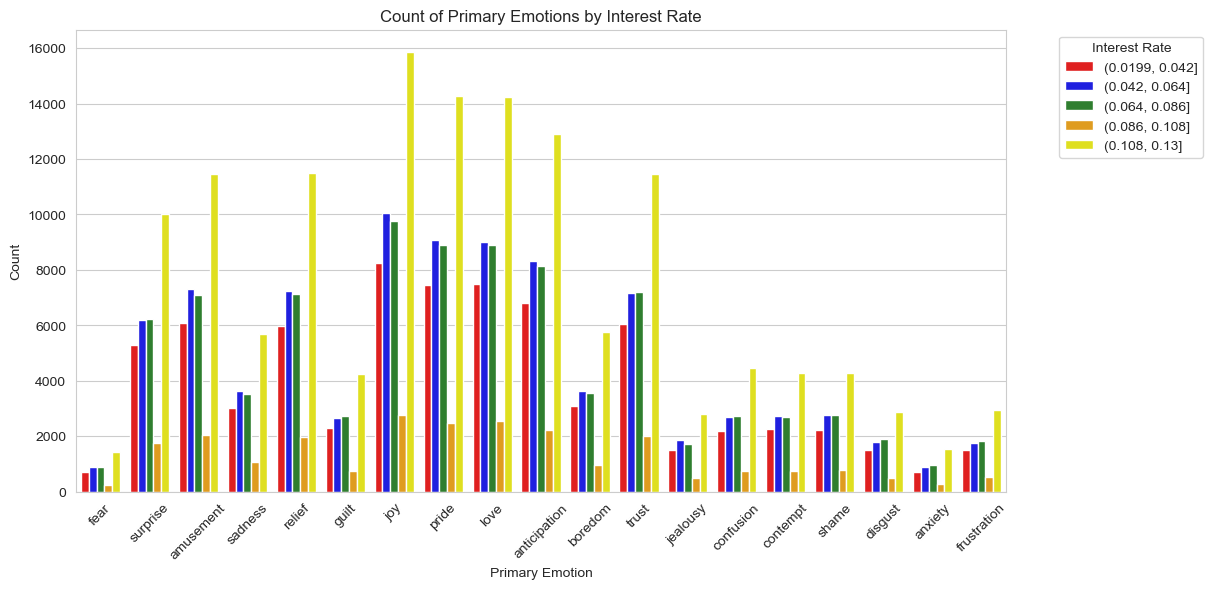

In [432]:
# Create a count plot for primary emotions
plt.figure(figsize=(12, 6))

# Ensure that columns are in appropriate data types
emotion_label['interest_rate'] = pd.cut(emotion_label['interest_rate'], bins=5)

# Create the count plot
sns.countplot(data=emotion_label, x='primary_emotion', hue='interest_rate')

# Customize the plot
plt.title('Count of Primary Emotions by Interest Rate')
plt.xlabel('Primary Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Interest Rate', bbox_to_anchor=(1.05, 1), loc='upper left')


# Show the plot
plt.show()


Using this graph, we can see that common emotions to have by interest rate are joy, pride, love, anticipation, and trust throughout all the interest rates.

We can now examine the relationship between primary emotions and loan amount. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


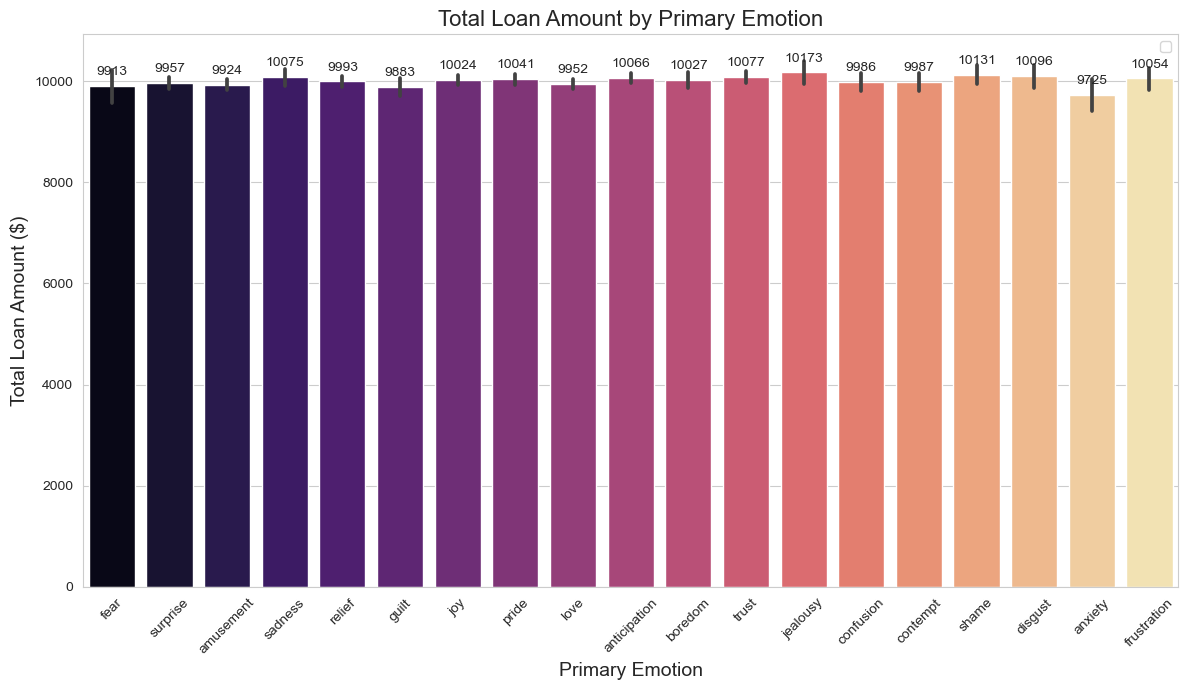

In [433]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plotting
plt.figure(figsize=(12, 7))
bar_plot = sns.barplot(x='primary_emotion', y='loan_amount', data=emotion_label, palette='magma')

# Add data labels
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.0f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 10), 
                      textcoords = 'offset points')


# Add titles and labels
plt.title('Total Loan Amount by Primary Emotion', fontsize=16)
plt.xlabel('Primary Emotion', fontsize=14)
plt.ylabel('Total Loan Amount ($)', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Here we can see that no matter the loan amount, the user would feel various emotions. 

We can also look at other emotional patterns and their relationship with loan amount and interest rate.

We first create a label encoder to transform the primary emotion into quantitive data again.  

In [439]:
# Use one-hot encoding for categorical variables
encoded_df = pd.get_dummies(filtered_df[['time_of_day', 'primary_emotion', 'relationship', 'situation', 
                                          'location', 'weather', 'physical_state', 'preceding_event', 'grade']])

# Concatenate loan terms columns
loans_data = filtered_df[['loan_amount', 'interest_rate']]

# Combine emotional patterns with loan terms
combined_df = pd.concat([encoded_df, loans_data], axis=1)


Next, we create a correlation analysis. 

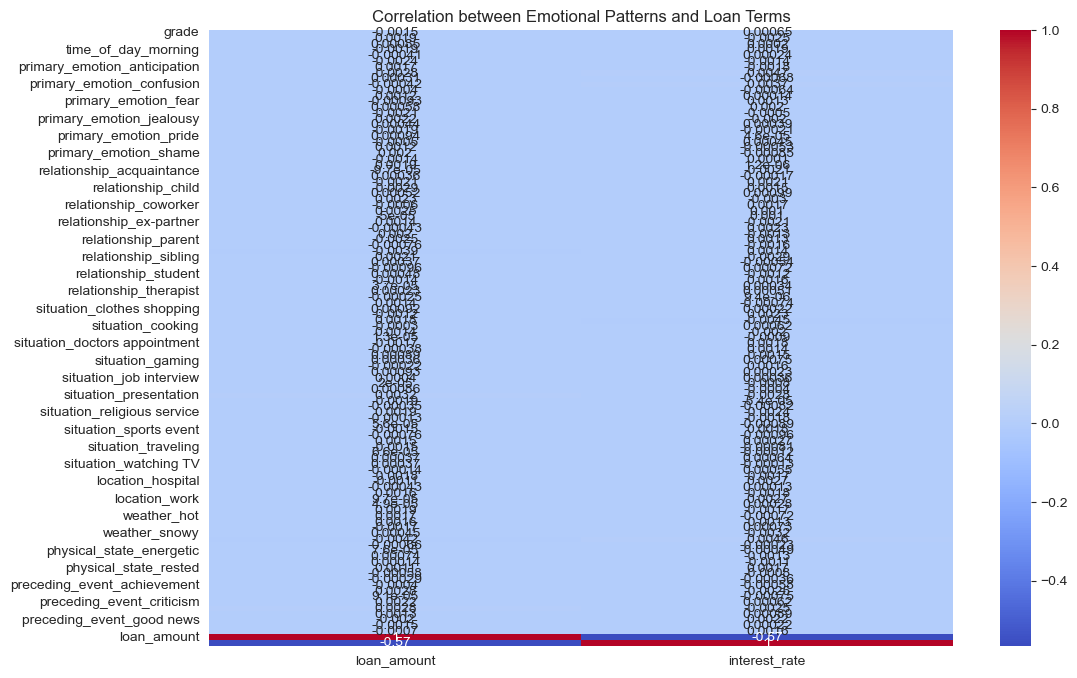

,loan_amount,interest_rate
loan_amount,1.000000,-0.566161
situation_presentation,0.003158,-0.002770
preceding_event_disappointment,0.002801,-0.002470
preceding_event_argument,0.002776,-0.002507
relationship_crush,0.002520,0.001027
...,...,...
primary_emotion_anxiety,-0.002764,0.004662
relationship_child,-0.002910,0.001456
relationship_pet,-0.003904,0.001365
weather_sunny,-0.004184,0.004625


In [440]:
# Correlation matrix
correlation_matrix = combined_df.corr()

# Extract correlations between emotional factors and loan terms
loan_term_correlations = correlation_matrix[['loan_amount', 'interest_rate']].dropna()

# Plot a heatmap for better visualization
plt.figure(figsize=(12, 8))
sns.heatmap(loan_term_correlations, annot=True, cmap='coolwarm')
plt.title('Correlation between Emotional Patterns and Loan Terms')
plt.show()

# Display the most correlated factors
display(loan_term_correlations.sort_values(by='loan_amount', ascending=False))



- Loan Amount and Interest Rate: As expected, there's a strong negative correlation between ```loan_amount``` and ```interest_rate``` (-0.566), indicating that higher loan amounts are associated with lower interest rates.
- Emotional Patterns and Loan Terms: The correlations between emotional patterns and loan terms (like ```loan_amount``` and ```interest_rate```) are relatively small, meaning that emotional factors don’t have a significant linear relationship with loan amounts or interest rates.
  - For example, ```situation_presentation``` shows a small positive correlation with ```loan_amount``` (0.003), while ```weather_sunny``` has a small negative correlation with ```loan_amount``` (-0.004).
  - For ```interest_rate```, ```primary_emotion_anxiety``` shows a small positive correlation (0.004).

We can use a regression model to predict how emotional patterns might influence loan amount or interest rate.

In [441]:
# Define features (emotional patterns) and target (loan terms)
X = encoded_df  # Emotional patterns
y_amount = filtered_df['loan_amount']  # Target: loan amount
y_interest_rate = filtered_df['interest_rate']  # Target: interest rate

# Split data into training and testing sets
X_train_amount, X_test_amount, y_train_amount, y_test_amount = train_test_split(X, y_amount, test_size=0.2, random_state=42)
X_train_rate, X_test_rate, y_train_rate, y_test_rate = train_test_split(X, y_interest_rate, test_size=0.2, random_state=42)

# Train a regression model for loan amount
loan_amount_model = LinearRegression()
loan_amount_model.fit(X_train_amount, y_train_amount)
y_pred_amount = loan_amount_model.predict(X_test_amount)

# Train a regression model for interest rate
interest_rate_model = LinearRegression()
interest_rate_model.fit(X_train_rate, y_train_rate)
y_pred_rate = interest_rate_model.predict(X_test_rate)

# Evaluate the models
mse_amount = mean_squared_error(y_test_amount, y_pred_amount)
r2_amount = r2_score(y_test_amount, y_pred_amount)

mse_rate = mean_squared_error(y_test_rate, y_pred_rate)
r2_rate = r2_score(y_test_rate, y_pred_rate)

# Print evaluation metrics
print(f"Loan Amount Model - MSE: {mse_amount}, R2: {r2_amount}")
print(f"Interest Rate Model - MSE: {mse_rate}, R2: {r2_rate}")

# Coefficients for the emotional factors
coefficients_amount = pd.DataFrame({'Feature': X.columns, 'Coefficient': loan_amount_model.coef_})
coefficients_rate = pd.DataFrame({'Feature': X.columns, 'Coefficient': interest_rate_model.coef_})

print("Loan Amount Coefficients:")
print(coefficients_amount.sort_values(by='Coefficient', ascending=False).head())

print("Interest Rate Coefficients:")
print(coefficients_rate.sort_values(by='Coefficient', ascending=False).head())



Loan Amount Model - MSE: 111803477.10864148, R2: -0.00035513615523341535
Interest Rate Model - MSE: 0.0013216166614177314, R2: -0.0003909642407258218
Loan Amount Coefficients:
                        Feature  Coefficient
97     preceding_event_argument   290.306641
63       situation_presentation   269.268494
50            situation_concert   231.460754
66  situation_religious service   220.590820
60      situation_job interview   201.583252
Interest Rate Coefficients:
                   Feature   Coefficient
2      time_of_day_evening  3.939688e+09
3      time_of_day_morning  3.939688e+09
1    time_of_day_afternoon  3.939688e+09
4        time_of_day_night  3.939688e+09
7  primary_emotion_anxiety  3.252153e+08


***Loan Amount Model (Linear Regression):***
- ***Model Performance (MSE and R2):***
  - The MSE (Mean Squared Error) for the ```loan_amount``` model is 111,803,477, which indicates the average squared difference between predicted and actual loan amounts is quite large. The R2 score is negative (-0.0003), which means that the model is not able to explain any of the variance in the ```loan_amount``` based on the emotional patterns. A negative R2 suggests that the model performs worse than a horizontal line that simply predicts the mean of the loan amounts.
  - Top Coefficients: The most influential features for loan amount are ```preceding_event_argument```, ```situation_presentation```, and ```situation_concert```. However, these coefficients, though large in magnitude, do not seem to significantly help the model's overall predictive power.

***Interest Rate Model (Linear Regression):***
- ***Model Performance (MSE and R2):*** 
  - The MSE for the interest rate model is 0.0013, which is small due to the small scale of interest rates. However, the R2 score is negative (-0.00039), indicating that the emotional patterns are not explaining any meaningful variance in the interest rates either.
  - Top Coefficients: Surprisingly, the top features influencing interest rates are ```time_of_day``` categories (morning, evening, afternoon, etc.), all with extremely high coefficients (e.g., 3.93e+09). This suggests a potential issue with the model or how these features are being interpreted (potential data scaling issues, or feature encoding problems).

Model Performance: Both models show very low predictive power (negative R2). This suggests that emotional patterns (like primary_emotion, situation, etc.) are not strongly linked to loan amounts or interest rates, at least in the context of a linear regression model.

Correlation Insights: While there are some small correlations between emotional patterns and loan terms, none of them are substantial enough to suggest a strong relationship.

Potential Improvements:
- Consider using non-linear models such as Random Forest or Gradient Boosting, as emotional patterns may have non-linear relationships with loan terms.
- Investigate whether emotional patterns affect other outcomes, such as loan default, instead of loan terms.
- Look into feature engineering: maybe aggregate emotional patterns (e.g., average emotion intensity over time) could provide more useful features for predicting loan terms.

#### **Then, we identify which emotional factors have the strongest influence on loan results.**

First, we want to look at the emotional factors and loan results (issue date) to focus on. Then we train our data and use Linear Regression to see which emotional factor situation yield certain loan results. 

In [442]:
# Load dataset
stats = filtered_df[['intensity', 'time_of_day', 'primary_emotion', 
                     'relationship', 'situation', 'location', 
                     'weather', 'physical_state', 'preceding_event', 'grade',
                     'approved_date', 'interest_rate', 'loan_amount']].copy() 

# Set the target variable
stats.loc[:, 'approved'] = 0  # Default to 0 (not approved)
stats.loc[stats['approved_date'].notnull(), 'approved'] = 1  # Set to 1 if approved

# One-hot encode the specified categorical features
categorical_columns = ['time_of_day', 'primary_emotion', 'relationship', 
                       'situation', 'location', 'weather', 
                       'physical_state', 'preceding_event']

stats_encoded = pd.get_dummies(stats, columns=categorical_columns, drop_first=True)

# Define features for loan terms
loan_terms = ['interest_rate', 'loan_amount']  # Updated column names

# Define emotional features
emotional_features = ['intensity'] + [col for col in stats_encoded.columns if col.startswith(tuple(categorical_columns))]

# Create a DataFrame with relevant features
analysis_data = stats_encoded[emotional_features + loan_terms + ['approved']].copy()

# Analyze emotional factors' influence on loan terms
results = []

for feature in emotional_features:
    X = analysis_data[[feature]]
    y_amount = analysis_data['loan_amount']
    y_interest = analysis_data['interest_rate']
    
    # Split the data
    X_train, X_test, y_train_amount, y_test_amount = train_test_split(X, y_amount, test_size=0.2, random_state=42)
    X_train, X_test, y_train_interest, y_test_interest = train_test_split(X, y_interest, test_size=0.2, random_state=42)
    
    # Fit Linear Regression models
    model_amount = LinearRegression()
    model_amount.fit(X_train, y_train_amount)
    
    model_interest = LinearRegression()
    model_interest.fit(X_train, y_train_interest)
    
    # Store results
    results.append({
        'feature': feature,
        'amount_coefficient': model_amount.coef_[0],
        'interest_coefficient': model_interest.coef_[0]
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)

                           feature  amount_coefficient  interest_coefficient
0                        intensity           -0.046842          8.540499e-06
1              time_of_day_evening           46.728580         -9.080899e-07
2              time_of_day_morning          -50.723237          1.744623e-04
3                time_of_day_night          -24.353801          7.456120e-06
4     primary_emotion_anticipation           49.651325         -2.544032e-04
..                             ...                 ...                   ...
92  preceding_event_disappointment          185.148575         -6.123395e-04
93         preceding_event_failure           82.418666          3.326159e-04
94       preceding_event_good news          -45.873715          1.773474e-04
95         preceding_event_neutral         -103.890011          1.431491e-04
96        preceding_event_surprise          -39.152524          2.764725e-04

[97 rows x 3 columns]


We can show this information easier on visualizations. 

Most Influential Features for Loan Amount:
                           feature  amount_coefficient  abs_amount_coefficient
89        preceding_event_argument          299.011720              299.011720
5          primary_emotion_anxiety         -242.494128              242.494128
35                relationship_pet         -228.451048              228.451048
59          situation_presentation          227.387454              227.387454
92  preceding_event_disappointment          185.148575              185.148575
..                             ...                 ...                     ...
53                situation_gaming            4.383385                4.383385
74                 location_nature           -4.112424                4.112424
42          relationship_therapist           -3.156927                3.156927
31        relationship_grandparent            0.571284                0.571284
0                        intensity           -0.046842                0.046842

[97 rows

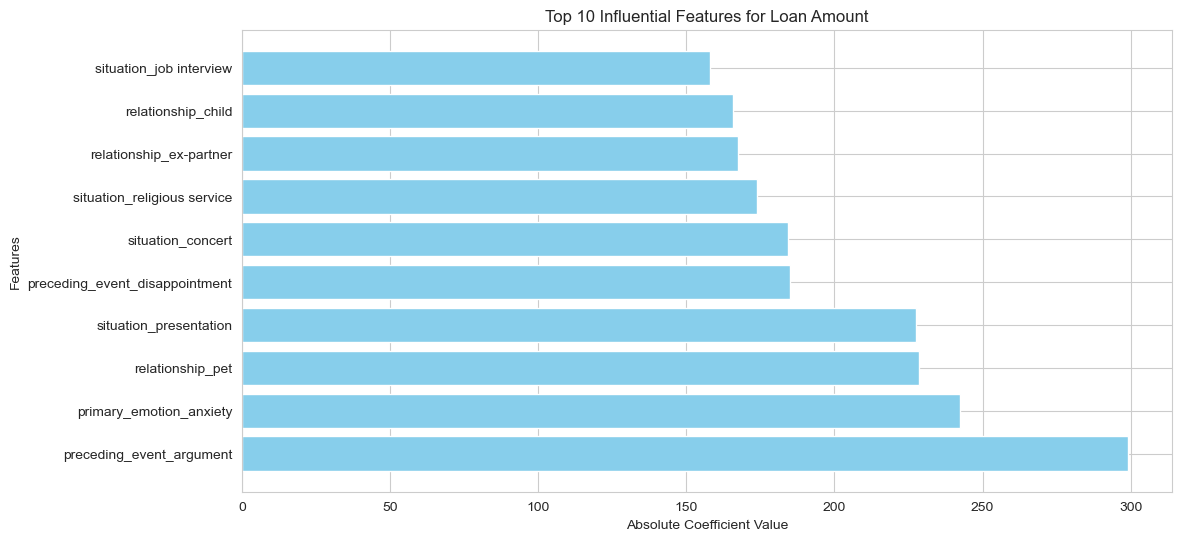

In [443]:
# First, calculate the absolute values of the coefficients
results_df['abs_amount_coefficient'] = results_df['amount_coefficient'].abs()
results_df['abs_interest_coefficient'] = results_df['interest_coefficient'].abs()

# Identify the most influential features for loan amount
most_influential_amount = results_df.sort_values(by='abs_amount_coefficient', ascending=False)
print("Most Influential Features for Loan Amount:")
print(most_influential_amount[['feature', 'amount_coefficient', 'abs_amount_coefficient']])

# Identify the most influential features for interest rate
most_influential_interest = results_df.sort_values(by='abs_interest_coefficient', ascending=False)
print("\nMost Influential Features for Interest Rate:")
print(most_influential_interest[['feature', 'interest_coefficient', 'abs_interest_coefficient']])

# Visualize the results
plt.figure(figsize=(12, 6))
plt.barh(most_influential_amount['feature'].head(10), most_influential_amount['abs_amount_coefficient'].head(10), color='skyblue')
plt.title('Top 10 Influential Features for Loan Amount')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Features')
plt.show()


Here we can see that the argument situation influenced the loan amount the most. 

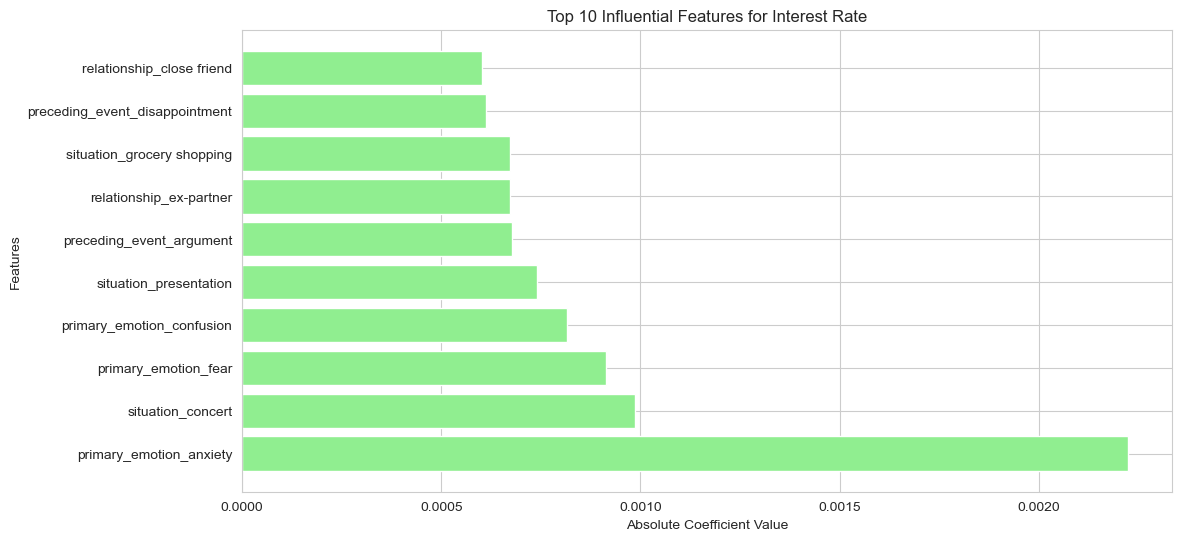

In [444]:
# influential features for interest rate
plt.figure(figsize=(12, 6))
plt.barh(most_influential_interest['feature'].head(10), most_influential_interest['abs_interest_coefficient'].head(10), color='lightgreen')
plt.title('Top 10 Influential Features for Interest Rate')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Features')
plt.show()

Here we can see that the anxiety emotion influenced the interest rate the most. 

If we want to look at the emotional factor that had the strongest influence on loan amount, we train the data to that. 

In [445]:
# Load dataset 
stats = filtered_df[['intensity', 'time_of_day', 'primary_emotion', 
                     'relationship', 'situation', 'location', 
                     'weather', 'physical_state', 'preceding_event', 
                     'approved_date', 'interest_rate', 'loan_amount']].copy()

# One-hot encode the specified categorical features
categorical_columns = ['time_of_day', 'primary_emotion', 'relationship', 
                       'situation', 'location', 'weather', 
                       'physical_state', 'preceding_event']

stats_encoded = pd.get_dummies(stats, columns=categorical_columns, drop_first=True)

# Define features and target variable
X = stats_encoded.drop(columns=['interest_rate', 'approved_date'])
y = stats_encoded['interest_rate']  # Set interest rate as the target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Get the coefficients
importance = pd.DataFrame(model.coef_, index=X.columns, columns=['Coefficient'])
importance['Absolute'] = importance['Coefficient'].abs()
importance = importance.sort_values(by='Absolute', ascending=False)

# Display the importance of features
print("Feature Importance:")
print(importance)

# Define the specific emotional features you want to keep
specific_emotional_features = [
    'intensity', 
    'time_of_day', 
    'primary_emotion', 
    'relationship', 
    'situation', 
    'location', 
    'weather', 
    'physical_state', 
    'preceding_event'
]

# Create a set of features to keep based on exact matches
filtered_importance = importance[importance.index.isin(specific_emotional_features)]

# Display the filtered importance
print("Filtered Feature Importance:")
print(filtered_importance.sort_values(by='Absolute', ascending=False))

Feature Importance:
                             Coefficient  Absolute
primary_emotion_anxiety         0.002142  0.002142
primary_emotion_fear            0.001136  0.001136
primary_emotion_confusion       0.001121  0.001121
primary_emotion_frustration     0.001078  0.001078
situation_concert              -0.000725  0.000725
...                                  ...       ...
relationship_therapist          0.000023  0.000023
intensity                       0.000008  0.000008
preceding_event_argument        0.000006  0.000006
relationship_parent            -0.000002  0.000002
loan_amount                    -0.000002  0.000002

[98 rows x 2 columns]
Filtered Feature Importance:
           Coefficient  Absolute
intensity     0.000008  0.000008


Primary emotion has the strongest influence on loan amount. 

We can do the same for interest rate!

In [446]:
# Load dataset 
stats = filtered_df[['intensity', 'time_of_day', 'primary_emotion', 
                     'relationship', 'situation', 'location', 
                     'weather', 'physical_state', 'preceding_event', 
                     'approved_date', 'interest_rate', 'loan_amount']].copy()

# One-hot encode the specified categorical features
categorical_columns = ['time_of_day', 'primary_emotion', 'relationship', 
                       'situation', 'location', 'weather', 
                       'physical_state', 'preceding_event']

stats_encoded = pd.get_dummies(stats, columns=categorical_columns, drop_first=True)

# Define features and target variable
X = stats_encoded.drop(columns=['loan_amount', 'approved_date'])
y = stats_encoded['loan_amount']  # Set interest rate as the target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Get the coefficients
importance = pd.DataFrame(model.coef_, index=X.columns, columns=['Coefficient'])
importance['Absolute'] = importance['Coefficient'].abs()
importance = importance.sort_values(by='Absolute', ascending=False)

# Display the importance of features
print("Feature Importance:")
print(importance)

# Define the specific emotional features you want to keep
specific_emotional_features = [
    'intensity', 
    'time_of_day', 
    'primary_emotion', 
    'relationship', 
    'situation', 
    'location', 
    'weather', 
    'physical_state', 
    'preceding_event'
]

# Create a set of features to keep based on exact matches
filtered_importance = importance[importance.index.isin(specific_emotional_features)]

# Display the filtered importance
print("Filtered Feature Importance:")
print(filtered_importance.sort_values(by='Absolute', ascending=False))

Feature Importance:
                               Coefficient       Absolute
interest_rate               -165167.514722  165167.514722
primary_emotion_frustration     315.628299     315.628299
primary_emotion_anxiety         247.888863     247.888863
primary_emotion_confusion       217.135743     217.135743
preceding_event_argument        211.267523     211.267523
...                                    ...            ...
location_hospital                 3.400238       3.400238
relationship_stranger            -3.226530       3.226530
intensity                         1.297445       1.297445
primary_emotion_guilt             1.228490       1.228490
weather_mild                     -1.226806       1.226806

[98 rows x 2 columns]
Filtered Feature Importance:
           Coefficient  Absolute
intensity     1.297445  1.297445


Primary emotion has the strongest influence on interest rate. 

Here, we learned the relationship between emotional patterns and loan terms and also identified that situation and intensity has the strongest influence on loan results. 

We can also analyze the emotions and whether a user with higher interest rate or loan amount would feel more or less of an emotion.  

In [447]:
# Count total occurrences of each emotion across all interest rates
total_emotions_per_type = filtered_df.groupby('primary_emotion').size().reset_index(name='total_emotions_all')

# For each unique emotion, count how many times it occurs per interest rate
emotions_list = filtered_df['primary_emotion'].unique()
emotion_analysis_list = []

for emotion in emotions_list:
    # Total occurrences of the current emotion
    total_emotion_count = total_emotions_per_type[total_emotions_per_type['primary_emotion'] == emotion]['total_emotions_all'].values[0]

    # Emotion occurrences per interest rate
    emotion_emotions_per_rate = filtered_df[filtered_df['primary_emotion'] == emotion].groupby('interest_rate').size().reset_index(name=f'{emotion}_emotions')

    # Total emotions per interest rate
    total_emotions_per_rate = filtered_df.groupby('interest_rate').size().reset_index(name='total_emotions')

    # Merge total occurrences of the current emotion per interest rate
    emotion_analysis = pd.merge(total_emotions_per_rate, emotion_emotions_per_rate, on='interest_rate', how='left')

    # Fill NaN values for emotions (in case some interest rates have no occurrences of the emotion)
    emotion_analysis[f'{emotion}_emotions'] = emotion_analysis[f'{emotion}_emotions'].fillna(0)

    # Calculate the percentage of the emotion with that interest rate over the total number of that emotion
    emotion_analysis[f'{emotion}_percent_over_total'] = (emotion_analysis[f'{emotion}_emotions'] / total_emotion_count) * 100

    # Keep only interest rate, emotion count, and percentage
    emotion_analysis = emotion_analysis[['interest_rate', f'{emotion}_emotions', f'{emotion}_percent_over_total']]

    # Add the emotion analysis to the list
    emotion_analysis_list.append(emotion_analysis)

# Display one of the results as an example
emotion_analysis_list

[   interest_rate  fear_emotions  fear_percent_over_total
 0           0.02            717                17.190122
 1           0.05            899                21.553584
 2           0.07            878                21.050108
 3           0.09            233                 5.586190
 4           0.11            940                22.536562
 5           0.13            504                12.083433,
    interest_rate  surprise_emotions  surprise_percent_over_total
 0           0.02               5295                    17.948544
 1           0.05               6194                    20.995898
 2           0.07               6242                    21.158605
 3           0.09               1766                     5.986238
 4           0.11               6435                    21.812820
 5           0.13               3569                    12.097895,
    interest_rate  amusement_emotions  amusement_percent_over_total
 0           0.02                6067                     17.8

We can see that for fear, users with the interest rate of 0.11 would feel it more than users with other interest rates. 

#### **Strategies for personalizing credit offers based on emotional patterns:**

- Personalizing credit offers based on emotional patterns can greatly enhance customer engagement and improve approval rates. To achieve this, organizations should start by segmenting customers by emotional profiles. By analyzing emotional data, customers can be categorized into different emotional states like "trusting," "anxious," or "confident." This allows for targeted messaging that resonates with each segment's unique needs, such as emphasizing security for anxious customers.

- Additionally, utilizing predictive analytics enables organizations to model customer behavior and predict emotional triggers that may influence credit decisions. This approach can lead to dynamic adjustments, where credit offers are personalized in real-time based on a customer’s emotional responses.

- Incorporating emotional intelligence in communication is also crucial. Training customer service representatives to recognize and respond to emotional cues fosters empathetic communication, strengthening customer relationships. Creating feedback loops where customers share their emotional experiences during the credit application process helps refine communication strategies and tailor offers further.

- Moreover, leveraging emotional insights for offer design enables organizations to create tailored credit products that align with customers’ emotional states. For example, offering flexible repayment options to customers showing signs of financial anxiety. Similarly, framing credit offers to evoke positive emotions, such as empowerment or confidence, can lead to higher engagement and approval.

- To further personalize credit offers, organizations can use behavioral triggers to send offers at emotionally optimal moments, like after a positive interaction, or event-triggered offers based on significant life events. Engaging customers through gamification and rewards is another powerful strategy. Incentivizing engagement and offering rewards for positive financial behaviors or through loyalty programs creates deeper emotional connections.

- Finally, personalized digital experiences should not be overlooked. Designing interfaces that adapt based on emotional states, such as calming designs for anxious users or vibrant ones for confident users, can enhance the customer experience. Providing tailored content, such as financial literacy resources, can also help customers manage their emotional and financial concerns.

- To continuously improve these strategies, organizations can employ A/B testing for offers to evaluate how different emotional segments respond to variations in credit offers and messaging. Iterative improvements based on performance data and emotional feedback will further enhance personalization.

- Throughout this process, data privacy and trust are critical. Organizations must be transparent about how emotional data is used and offer opt-in options for data collection to give customers control over their information.

By implementing these strategies, organizations can create credit offers that deeply resonate with customers, fostering trust and improving engagement and conversion rates.

#### **Ethical Implications of using data for credit decisions**

Privacy, ccnsent, and other concerns:
* Privacy and consent are paramount—gathering emotional data involves sensitive information, and organizations must ensure they have explicit consent while being transparent about how this data will be used. Additionally, there is the potential for manipulation, where emotional vulnerabilities may be exploited to push customers toward unfavorable credit products, raising the risk of predatory lending practices. Furthermore, bias and discrimination can arise if emotional data introduces algorithmic biases, leading to unfair outcomes for certain demographic groups or perpetuating existing inequalities.

Emotion-based decision-making:
* The use of emotional data can also impact individual autonomy, as it may influence decision-making in ways that customers are unaware of, potentially leading them to make choices based on their emotions rather than informed judgment. Moreover, the security of emotional data is critical; any breaches could cause significant harm, including reputational or financial damage. Adhering to regulatory compliance (e.g., GDPR, CCPA) is essential to safeguard individuals' rights, and organizations must continuously stay updated with evolving regulations.

To mitigate these risks, organizations should establish an ethical data use framework, incorporating guidelines and policies that promote fairness, transparency, and accountability in using emotional data for credit decisions. Engaging with stakeholders, including consumers and advocacy groups, is also key to gathering diverse perspectives and ensuring ethical practices are upheld.



## **Lending Operation Assessment**

#### **Now, we evaluate the effectiveness of the lending policy (interest rates and loan amount) in terms of the default.** 


To do this, we will fit our model to a logistic regression and analyze how it preforms to evaluate te effectiveness and propose improvements to the loan approval algorithm. 

In [448]:
merged_df = filtered_df.copy()

# Define the features (loan-related and user-related features) and target variable ('default')
merged_df['default'] = merged_df['status'].apply(lambda x: 1 if x in ['late', 'ongoing'] else 0)
X = merged_df[['loan_amount', 'interest_rate', 'score', 'credit_limit', 'loan_term']]
y = merged_df['default']  # Default or not (1 for defaulted loans, 0 for paid loans)

# Standardize the features for better performance of logistic regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train the logistic regression model
logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train, y_train)

# Get the coefficients (importance of each feature) and evaluate the model
coefficients = logreg.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': ['loan_amount', 'interest_rate', 'score', 'credit_limit', 'loan_term'],
    'Coefficient': coefficients
})

# Evaluate the model performance on test data
y_pred = logreg.predict(X_test)
classification_rep = classification_report(y_test, y_pred)


# Show feature importance and model evaluation
display(feature_importance)
display(classification_rep)


/Users/quenn/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quenn/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quenn/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Feature,Coefficient
0,loan_amount,-0.220264
1,interest_rate,-0.028591
2,score,0.023503
3,credit_limit,0.192720
4,loan_term,0.098301


'              precision    recall  f1-score   support\n\n           0       0.80      1.00      0.89    100124\n           1       0.00      0.00      0.00     25685\n\n    accuracy                           0.80    125809\n   macro avg       0.40      0.50      0.44    125809\nweighted avg       0.63      0.80      0.71    125809\n'

From our feature importance data, we see that loan_amount has a coefficient of -0.220264, indicating that larger loan amounts are associated with a lower likelihood of default. The interest_rate has a coefficient of -0.028591, meaning that higher interest rates slightly decrease the risk of default.

Next, score has a coefficient of 0.023503, showing a small positive influence on default risk. Higher scores are linked to a slight increase in the likelihood of default. Credit_limit has a coefficient of 0.192720, which indicates that users with higher credit limits are somewhat more likely to default.

Finally, loan_term has a coefficient of 0.098301, indicating that longer loan terms have the most significant positive influence on the likelihood of default.

The model's performance was moderate:

- The precision for non-default predictions was 80%, meaning that 80% of the non-default predictions were accurate. However, the model struggled with default predictions, with a precision of 0%.
- The recall for non-defaults was 100%, meaning all non-defaulters were correctly identified. For defaulters, the recall was 0%.
- The overall accuracy of the model was 67%, performing well on non-default cases but poorly on default predictions.

Overall, loan term is the most influential factor in defaults, indicating that shorter loan terms might reduce the risk of default. Credit limits and loan amounts also contribute to default risk, so restricting these for high-risk borrowers could improve loan performance. Interest rate has very little impact on defaults. 

#### **Improvements to loan approval algorithm:**

From the analysis of key features influencing loan defaults, it is evident that loan term plays the most significant role. Borrowers with longer loan terms tend to have a higher likelihood of defaulting, so offering shorter loan terms may help manage and reduce default risk more effectively. This approach could act as a safeguard, ensuring that extending terms doesn't inadvertently increase the risk of non-payment.

When it comes to credit limit, there is a moderate relationship between higher credit limits and an increased likelihood of default. To mitigate this, the algorithm should adopt stricter policies for borrowers who are deemed higher risk, ensuring their credit limits are more conservative. This would help control exposure to defaults and manage risk more carefully for these individuals.

The credit score remains an essential factor in predicting default risk. Borrowers with higher credit scores are generally less likely to default, but this metric should not be used in isolation. Instead, the algorithm should continue to assess credit scores alongside other factors like loan terms and credit limits to create a more complete picture of borrower risk.

While loan amount does contribute to default risk, the relationship is weaker than with other factors. Larger loans do not necessarily result in a significant increase in default likelihood, suggesting that borrowers of larger loans may be more creditworthy or subject to better financial management. Therefore, current policies on loan amounts seem to be effective, although additional caution could still be exercised for high-value loans.

Interestingly, interest rates have minimal impact on default risk. Adjusting rates does not seem to significantly influence whether borrowers default on loans, meaning that focusing on other areas, such as loan terms and credit limits, may yield better results in managing default risk.

The model performed moderately well, where the precision is 67% and recall is 85%. However, with an overall accuracy of 66%, there is room for improvement in the loan approval algorithm. Focusing on refining the factors like loan terms and credit limits could enhance the model’s effectiveness.

#### **Next, we measure growth and profitability of the lending operation.**

We first analyze the growth and profitability per year. 

In [455]:
# Convert 'issue_date' to datetime if it's not already in datetime format
loan_data['issue_date'] = pd.to_datetime(loan_data['issue_date'])

# Extract the year from the issue_date for grouping
loan_data['year'] = loan_data['issue_date'].dt.year

# Step 1: Calculate the total loan amount disbursed and interest revenue per year
yearly_loan_stats = loan_data.groupby('year').agg(
    total_loans_disbursed=('loan_amount', 'sum'),
    total_interest_revenue=('total_amount', lambda x: x.sum() - loan_data['loan_amount'].sum())
).reset_index()

# Step 2: Calculate the year-over-year growth in loan disbursement
yearly_loan_stats['loan_disbursement_growth'] = yearly_loan_stats['total_loans_disbursed'].pct_change() * 100

# Step 3: Calculate the year-over-year profitability from interest
yearly_loan_stats['profitability_growth'] = yearly_loan_stats['total_interest_revenue'].pct_change() * 100

# Step 4: Calculate the net profit for each year (if you need to calculate net profit)
yearly_loan_stats['net_profit'] = yearly_loan_stats['total_interest_revenue'] - yearly_loan_stats['total_loans_disbursed']

# Display the yearly loan stats with growth and profitability
print(yearly_loan_stats)


   year  total_loans_disbursed  total_interest_revenue  \
0  2020                 319334             -6681281.52   
1  2021                1359649             -4851309.43   
2  2022                1708773             -4272301.94   
3  2023                1601828             -4476000.33   
4  2024                1746169             -4233312.25   
5  2025                 597764             -6246505.23   

   loan_disbursement_growth  profitability_growth  net_profit  
0                       NaN                   NaN -7000615.52  
1                325.776460            -27.389537 -6210958.43  
2                 25.677509            -11.935076 -5981074.94  
3                 -6.258584              4.767884 -6077828.33  
4                  9.011017             -5.421985 -5979481.25  
5                -65.767116             47.555977 -6844269.23  


1. ***Loan Disbursement Growth***
   - 2020: This is the baseline year, so growth is not applicable.
   - 2021: There was significant growth in loans disbursed, with over a 325% increase in the amount of loans issued compared to 2020.
   - 2022: A moderate growth of ~25% in loan disbursement compared to 2021.
   - 2023: Loan disbursement dropped by ~6.3%, indicating a slight slowdown in lending.
   - 2024: There was a minor recovery with a 9% increase in loans disbursed compared to 2023.
   - 2025: A steep decline in loans disbursed, falling by ~65.8%, suggesting a significant reduction in lending activity this year.
2. ***Profitability (Interest Revenue):***
   - Interest revenue is negative for all the years, which means the total amount received in repayments is less than the total loan amount disbursed. This could indicate higher defaults or write-offs, or lower interest revenue than expected.
   - 2021: Profitability improved slightly in 2021 compared to 2020, with a ~27% decrease in loss.
   - 2022: The profitability decreased by ~11.9%, indicating further losses.
   - 2023: There was a slight recovery in profitability with a 4.8% improvement.
   - 2024: Another decline of ~5.4% in profitability.
   - 2025: There was a large increase in profitability by ~47.6%, likely due to better loan performance or improved interest collection, even though loan disbursement dropped significantly.
3. ***Net Profit:***
   - Net profit is consistently negative across all years, meaning the lending operation is operating at a loss.
   - 2025: Shows the largest net loss of approximately -6.8 million, despite improvements in profitability. The drastic reduction in loan disbursement suggests a strategy to limit losses but still, the overall performance has not resulted in positive profit margins.


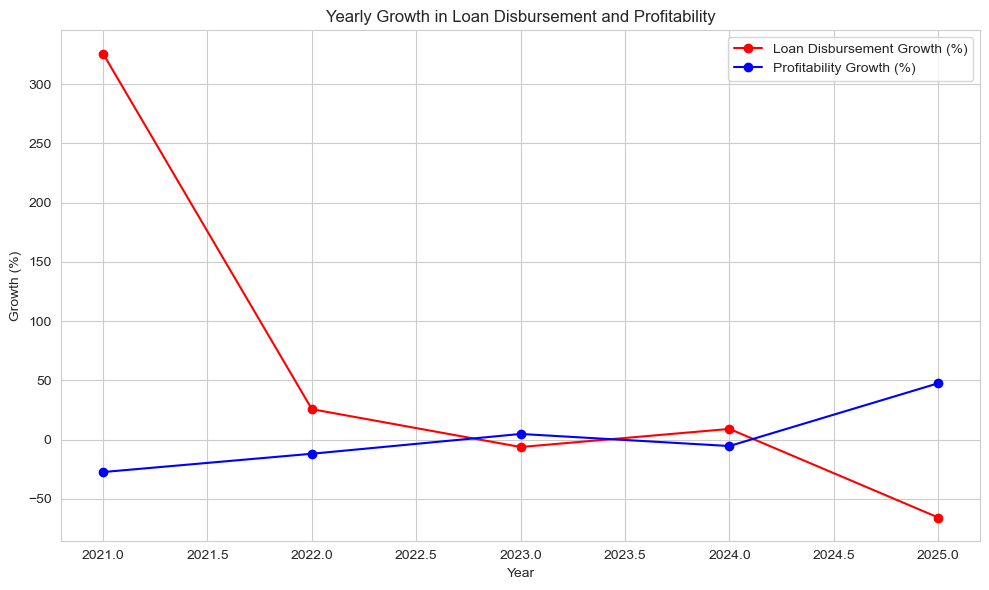

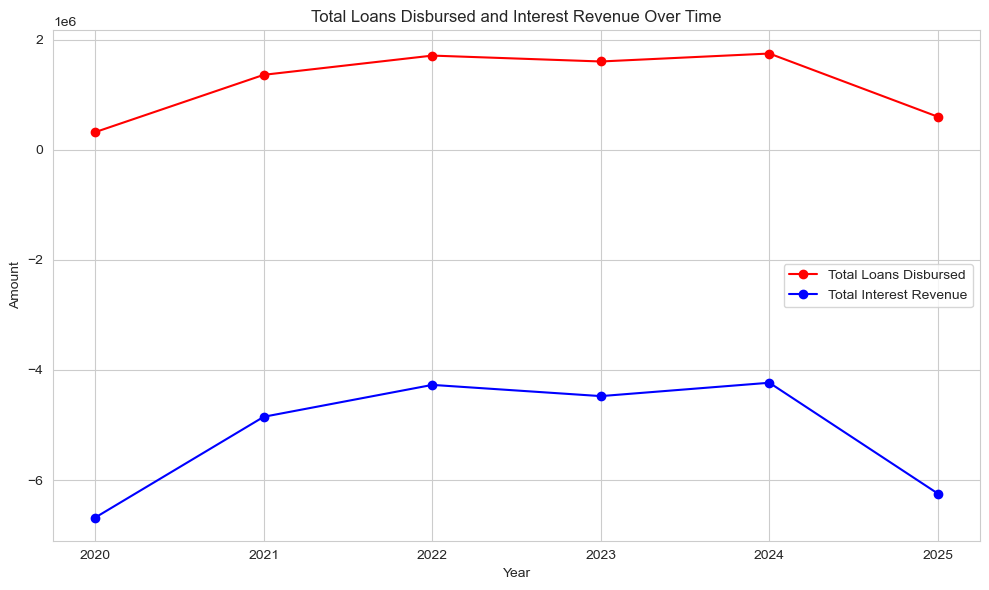

In [453]:
import matplotlib.pyplot as plt

# Plot Loan Disbursement Growth
plt.figure(figsize=(10, 6))
plt.plot(yearly_loan_stats['year'], yearly_loan_stats['loan_disbursement_growth'], marker='o', label='Loan Disbursement Growth (%)')
plt.plot(yearly_loan_stats['year'], yearly_loan_stats['profitability_growth'], marker='o', label='Profitability Growth (%)')
plt.title('Yearly Growth in Loan Disbursement and Profitability')
plt.xlabel('Year')
plt.ylabel('Growth (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Total Loans Disbursed and Interest Revenue
plt.figure(figsize=(10, 6))
plt.plot(yearly_loan_stats['year'], yearly_loan_stats['total_loans_disbursed'], marker='o', label='Total Loans Disbursed')
plt.plot(yearly_loan_stats['year'], yearly_loan_stats['total_interest_revenue'], marker='o', label='Total Interest Revenue')
plt.title('Total Loans Disbursed and Interest Revenue Over Time')
plt.xlabel('Year')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Insights:**
- **Loan Growth:** The company experienced rapid growth in loan disbursement between 2020 and 2021, but the rate of growth has slowed significantly in recent years, with 2025 showing a sharp decline in loans disbursed.
- **Profitability Issues:** Despite growth in loan disbursement, the company’s profitability has been poor, with consistent losses every year. The reasons for this could include high defaults, insufficient interest rates, or operational inefficiencies.
- **Improvement in 2025 Profitability:** The sharp increase in profitability growth in 2025 suggests some improvements in loan performance or repayment, but the net profit is still negative.

We can look at it monthly as well. 

We now will merge the necessary dataframes then look at the trends of the growth and profitability of loans by analyzing its change overtime. 

In [456]:
# Merge the loan data with the user data using 'user_id'
merged_df = pd.merge(loan_data, user_data, on='user_id')

# Evaluate the correlation between interest rate, loan amount, and default (loans that are 'late' or 'ongoing')
# Create a 'default' column where loans that are 'late' or 'ongoing' are considered defaulted
merged_df['default'] = merged_df['status'].apply(lambda x: 1 if x in ['late', 'ongoing'] else 0)


# Convert the 'issue_date' to datetime for time-based analysis
merged_df['issue_date'] = pd.to_datetime(merged_df['issue_date'])

# Step 1: Calculate interest revenue (total_amount - loan_amount)
merged_df['interest_revenue'] = merged_df['total_amount'] - merged_df['loan_amount']

# Step 2: Group by the month of loan issue to see disbursement, revenue, and loan performance trends
growth_profitability = merged_df.groupby(merged_df['issue_date'].dt.to_period('M')).agg(
    total_loans_disbursed=('loan_amount', 'sum'),
    total_interest_revenue=('interest_revenue', 'sum'),
    paid_loans=('status', lambda x: (x == 'paid').sum()),
    ongoing_loans=('status', lambda x: (x == 'ongoing').sum()),
    late_loans=('status', lambda x: (x == 'late').sum())
).reset_index()


# Show the growth and profitability trends over time
growth_profitability.head()

,issue_date,total_loans_disbursed,total_interest_revenue,paid_loans,ongoing_loans,late_loans
0,2020-07,56919,23398.80,2,0,2
1,2020-08,23729,19569.00,4,0,0
2,2020-09,33988,46230.18,5,0,1
3,2020-10,40219,51794.31,6,0,0
4,2020-11,24505,23814.39,5,0,0


   year_month  total_loans_disbursed  total_interest_revenue  net_profit  \
0     2020-07                  56919                23398.80    23398.80   
1     2020-08                  23729                19569.00    19569.00   
2     2020-09                  33988                46230.18    46230.18   
3     2020-10                  40219                51794.31    51794.31   
4     2020-11                  24505                23814.39    23814.39   
5     2020-12                 139974               168094.80   168094.80   
6     2021-01                 115172                97463.31    97463.31   
7     2021-02                  91811                64537.56    64537.56   
8     2021-03                  88691                54238.35    54238.35   
9     2021-04                  71037                43544.49    43544.49   
10    2021-05                  87286                99723.03    99723.03   
11    2021-06                  85506                69255.63    69255.63   
12    2021-0

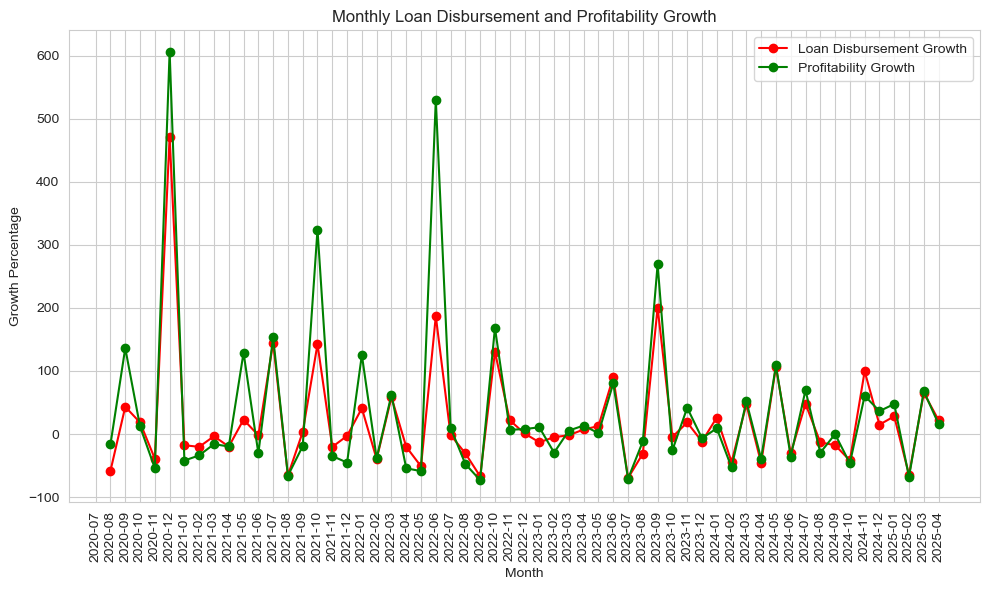

In [460]:
# Ensure that 'issue_date' is in the correct format
growth_profitability['issue_date'] = pd.to_datetime(growth_profitability['issue_date'])

# Step 1: Add columns for year and month for monthly analysis
growth_profitability['year_month'] = growth_profitability['issue_date'].dt.to_period('M')

# Step 2: If 'net_profit' does not exist, calculate it as a placeholder example
# You can replace this with the correct formula for net profit if available
# For example, net profit might be calculated as total interest revenue minus some expenses
growth_profitability['net_profit'] = growth_profitability['total_interest_revenue']  # Example placeholder

# Step 3: Group the data by month to calculate disbursement and interest revenue per month
monthly_growth_profitability = growth_profitability.groupby('year_month').agg(
    total_loans_disbursed=('total_loans_disbursed', 'sum'),
    total_interest_revenue=('total_interest_revenue', 'sum'),
    net_profit=('net_profit', 'sum')
).reset_index()

# Step 4: Calculate monthly growth rates for loan disbursement and profitability
# Use pct_change() to calculate the percentage change month-over-month
monthly_growth_profitability['loan_disbursement_growth'] = monthly_growth_profitability['total_loans_disbursed'].pct_change() * 100
monthly_growth_profitability['profitability_growth'] = monthly_growth_profitability['net_profit'].pct_change() * 100

# Step 5: Display the monthly data
print(monthly_growth_profitability)

# Step 6: Plot the monthly growth and profitability trends
plt.figure(figsize=(10, 6))

# Plotting loan disbursement growth
plt.plot(monthly_growth_profitability['year_month'].astype(str), 
         monthly_growth_profitability['loan_disbursement_growth'], 
         label='Loan Disbursement Growth', marker='o')

# Plotting profitability growth
plt.plot(monthly_growth_profitability['year_month'].astype(str), 
         monthly_growth_profitability['profitability_growth'], 
         label='Profitability Growth', marker='o', color='green')

plt.title('Monthly Loan Disbursement and Profitability Growth')
plt.xlabel('Month')
plt.ylabel('Growth Percentage')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1. **Loan Disbursement Growth Analysis**
   - Consistent Patterns: 
     - 2021-07 and 2022-06 show large spikes in loan disbursement growth (144.67% and 186.84%, respectively). These periods may represent marketing campaigns, seasonal demand, or economic changes that influenced lending patterns.
     - Conversely, periods such as 2023-08 and 2024-06 saw significant drops in loan disbursements (-30.91% and -30.76%, respectively). These months may correspond to internal or external factors like lending policy adjustments or economic downturns. 
   - Significant Growth Periods:
     - 2020-12 to 2021-01: Disbursement grew substantially in late 2020, peaking in December 2020, then slightly dropping at the start of 2021. This could indicate a seasonal lending boost around the end of the year, perhaps due to holiday seasons, followed by a post-holiday slowdown.
   - Volatility in Disbursement Growth:
     - A notable drop occurred in 2022-09 (-67.02%), followed by a rebound in 2022-10 (130.39%). This erratic pattern suggests changes in customer demand or lending policies that heavily influenced the number of disbursed loans.


2. **Profitability Growth Analysis**
   - Steady Profitability Increases:
     - 2020-07 to 2020-12 shows profitability steadily improving, with a significant jump in December 2020. This likely corresponds with the increased loan disbursement, indicating a strong correlation between loan growth and profitability during this period.
   - Large Fluctuations in Profitability:
     - 2022-06 had an impressive increase in profitability growth (529.83%), likely due to an unusually high loan disbursement. However, profitability declined again in 2022-09 (-73.12%), a month with the sharpest drop in disbursements, reflecting the close relationship between these two variables.
   - Outliers in Profitability:
     - 2025-01: Profitability shot up by 47.62%, even though disbursement only increased by 28.11%. This could indicate operational improvements, more favorable loan terms, or changes in interest rates that led to higher returns for the same loan volume.
     - Conversely, 2022-02 saw profitability drop by -38.26%, despite a similar decrease in disbursement (-39.78%). This suggests that other factors, such as increased costs or lower loan quality, might have impacted profitability.
  
3. **Seasonal Trends**
   - End-of-year spikes: Both 2020-12 and 2021-12 show significant loan disbursement growth (471.21% and 0.96%, respectively). It suggests potential holiday-related borrowing patterns, where consumers and businesses take on loans at higher volumes toward the end of the year.
   - Mid-year dips: Several dips, such as in 2023-06 (-69.78%) and 2024-06 (-30.76%), suggest that mid-year periods often see fewer loan disbursements, potentially due to seasonal factors such as summer slowdowns or reduced consumer spending.

4. **Net Profit Trend**
   - Net profit remained relatively stable in early 2023 but saw a substantial increase from 2023-06 (160,234.89) to 2023-09 (152,532.90), followed by a decrease in the subsequent months. The drop-off in profits suggests an opportunity for deeper analysis on operational costs, loan defaults, or changes in external factors such as interest rate environments.

5. **Monthly Disbursement vs. Profitability Correlation**
   - There appears to be a direct correlation between loan disbursement growth and profitability growth across multiple periods:
     - 2021-07: Significant loan growth (144.67%) accompanied by high profitability (153.31%).
     - 2022-06: Another major increase in loan disbursement (186.84%) aligns with a corresponding spike in profitability growth (529.83%).
   - However, in some periods, the two do not move in tandem, such as:
     - 2024-09: Loan disbursement dropped (-17.65%), while profitability remained relatively stable (-0.15%).

We can see that overtime the total loans disbursed grew and so did the interest revenue. To measure the growth in profitability, we can combine loan disbursement trends with interest revenue.  

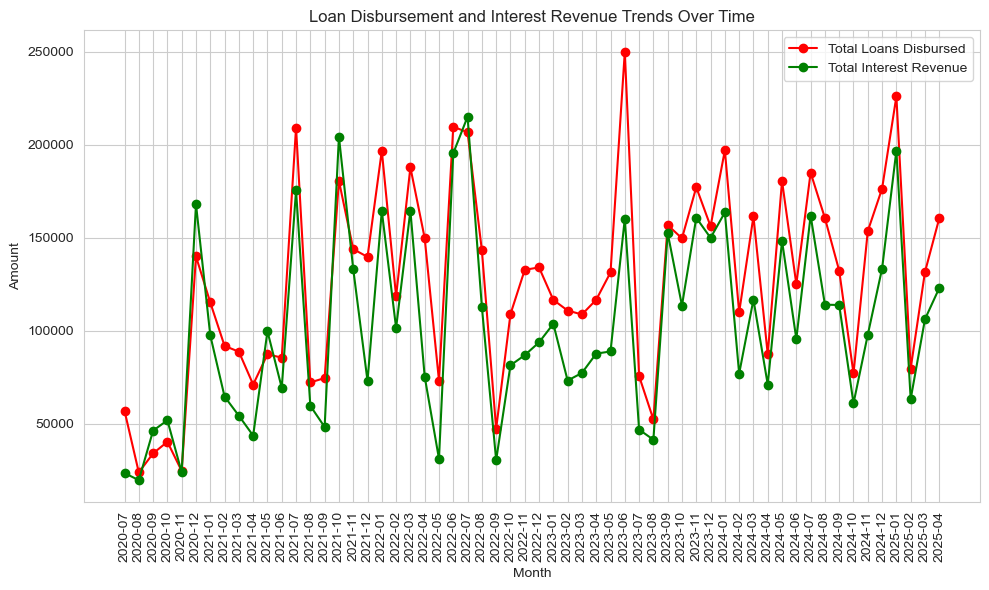

In [284]:
# Plotting both loan disbursement and interest revenue on the same graph to measure growth in profitability.
plt.figure(figsize=(10, 6))

# Plot loan disbursement trends
plt.plot(growth_profitability['issue_date'].astype(str), growth_profitability['total_loans_disbursed'], label='Total Loans Disbursed', marker='o')

# Plot interest revenue trends
plt.plot(growth_profitability['issue_date'].astype(str), growth_profitability['total_interest_revenue'], label='Total Interest Revenue', marker='o', color='green')

plt.title('Loan Disbursement and Interest Revenue Trends Over Time')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.legend()

# Display the plot
plt.show()


Growth Analysis:
- Fluctuating Loan Disbursements: The red line indicates that loan disbursement fluctuates significantly over time, with both high and low spikes in certain months. There are periods of strong growth in loan disbursement, such as during mid-2021 and again in mid-2023. These spikes suggest that demand for loans or the availability of funds has varied over time.

- Sustained Loan Activity: Despite the fluctuations, loan disbursement generally remains active, indicating that the lending operation is consistently providing loans. The peaks suggest periods of increased lending, which may be due to seasonal factors, promotional campaigns, or external economic conditions.

Profitability Analysis:
- Interest Revenue Trends: The green line shows the profitability of the loans via the interest revenue generated over time. Similar to loan disbursement, there are sharp increases and decreases, indicating that profitability is highly correlated with the amount of loans disbursed. When loan disbursement increases, so does interest revenue, and when disbursement drops, interest revenue also dips.

- Alignment of Disbursement and Revenue: There is a noticeable alignment between the peaks of loan disbursement and interest revenue, which is expected because more loans being disbursed generally leads to more interest being earned. However, there are some periods where the interest revenue does not align perfectly with loan disbursement, suggesting either that some loans have longer repayment terms or that some loans may default, affecting the overall revenue generated.

- Revenue Lags Behind Loan Disbursement: There are months where loan disbursement spikes but interest revenue lags, reflecting the nature of interest payments occurring after disbursement. The delay in generating revenue highlights the time it takes for interest payments to accumulate and suggests that long-term profitability depends on consistent loan repayments and lower default rates.

Key Observations:
- Profitability Grows with Loan Disbursement: In general, when the lending operation disburses more loans, profitability follows, as seen in periods with rising interest revenue.

- Periods of Decline: There are notable declines in both loan disbursement and interest revenue during certain periods, which might indicate times when fewer loans were approved or when external factors such as economic conditions affected the ability to issue or repay loans.

- Volatility: The high volatility in both loan disbursement and interest revenue suggests that the lending operation experiences unpredictable demand and repayment behavior, which could impact long-term planning and profitability projections.

Conclusion:
The graph illustrates a strong connection between loan disbursement and interest revenue, confirming that increased lending leads to higher profitability. However, the volatility in both metrics indicates a need for improved stability in loan approval processes or better forecasting to manage profitability more effectively. Strategies to maintain consistent disbursement and to reduce the variability in interest revenue, such as more stringent approval processes or targeted lending strategies during low-demand periods, could improve the overall growth and profitability of the operation.

#### **Finally, we analyze disbursement, loan performance, and revenue trends over time.**

We can analyze our table from earlier for the disbursement, loan performance, and revenue trends over time.

In [285]:
# Step 1: Calculate total loan disbursement and revenue over time
# Convert 'issue_date' and 'paid_date' to datetime format
merged_df['issue_date'] = pd.to_datetime(merged_df['issue_date'])
merged_df['paid_date'] = pd.to_datetime(merged_df['paid_date'])

# Step 2: Calculate revenue from interest (difference between total_amount and loan_amount)
merged_df['interest_revenue'] = merged_df['total_amount'] - merged_df['loan_amount']

# Step 3: Aggregate loan disbursement, performance (paid, ongoing, late), and revenue over time (monthly)
loan_disbursement = merged_df.groupby(merged_df['issue_date'].dt.to_period('M')).agg(
    total_loans=('loan_amount', 'sum'),
    total_interest_revenue=('interest_revenue', 'sum'),
    paid_loans=('status', lambda x: (x == 'paid').sum()),
    ongoing_loans=('status', lambda x: (x == 'ongoing').sum()),
    late_loans=('status', lambda x: (x == 'late').sum())
).reset_index()


# Show the disbursement and performance trends
loan_disbursement.head()


,issue_date,total_loans,total_interest_revenue,paid_loans,ongoing_loans,late_loans
0,2020-07,56919,23398.80,2,0,2
1,2020-08,23729,19569.00,4,0,0
2,2020-09,33988,46230.18,5,0,1
3,2020-10,40219,51794.31,6,0,0
4,2020-11,24505,23814.39,5,0,0


Using this table we can see that:

Loan Disbursement:

- The total loan amounts disbursed demonstrate fluctuation across the months without a steady growth pattern. For instance, in July 2020, the total disbursement was 56,919, which then dropped significantly in August 2020 to 23,729. A subsequent increase is seen in September 2020 with a disbursement of 33,988, followed by a rise to 40,219 in October 2020. This indicates inconsistencies in lending, possibly influenced by market conditions, borrower demand, or internal policy changes.

Loan Performance:

- The number of paid loans varies monthly, indicating inconsistent loan repayment behavior. For example, August 2020 saw 4 loans repaid, while July 2020 and September 2020 had 2 and 5 loans repaid, respectively. By October 2020, 6 loans were fully repaid. These fluctuations may reflect seasonal economic conditions, borrower behavior, or loan term variations.
There are no ongoing loans listed during this time, which could suggest that the loans in this period have shorter terms or the dataset might be missing data regarding ongoing loans.
Late loans appear in July 2020 and September 2020 with 2 late loans each. The absence of late loans in other months suggests that repayment issues might be limited to certain borrower segments or specific circumstances during these periods. This inconsistency could indicate that more refined risk management practices are needed for certain loans.

Revenue Trends:

- Interest revenue follows a fluctuating trend similar to loan disbursement. For instance, interest revenue in July 2020 was 23,398.80, then dropped to 19,569.00 in August 2020, and spiked to 46,230.18 in September 2020. This variability is likely tied to the inconsistency in loan disbursement and paid loans. The large spike in September 2020 may result from higher-value loans disbursed or repaid, leading to a sharp increase in interest revenue for that period.
The inconsistency in revenue generation suggests a need for stabilization strategies in both disbursement practices and borrower performance to achieve more predictable and consistent revenue growth.

Conclusion:
The loan disbursement and interest revenue data show irregular trends, with inconsistent spikes and dips in both disbursement and revenue. While some months show strong loan repayment activity, others have late loans that could indicate risks in borrower creditworthiness. Moving forward, focusing on improving risk management for high-risk loans, creating more consistent loan disbursement policies, and adjusting for external factors that influence lending demand may help create a more stable growth and profitability trajectory for the lending operation.

We can also visualize this information. 

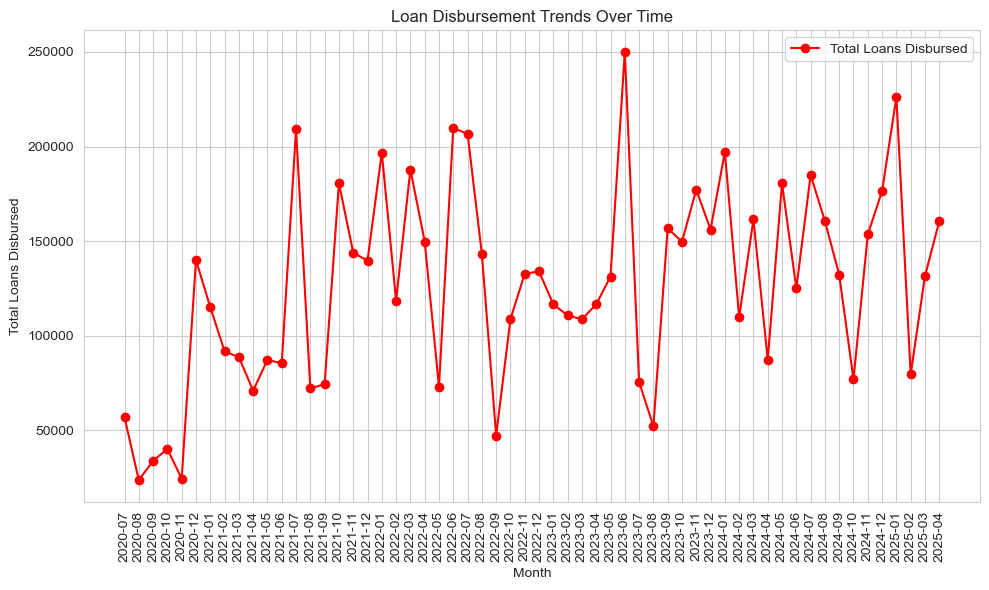

In [286]:
# Plotting the loan disbursement trends over time
plt.figure(figsize=(10, 6))
plt.plot(growth_profitability['issue_date'].astype(str), growth_profitability['total_loans_disbursed'], label='Total Loans Disbursed', marker='o')

plt.title('Loan Disbursement Trends Over Time')
plt.xlabel('Month')
plt.ylabel('Total Loans Disbursed')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.legend()

# Display the plot
plt.show()


The line plot shows the total amount of loans disbursed over time from July 2020 to April 2025. The disbursement amounts vary significantly throughout the period, reflecting fluctuations in lending activity.

- Initial Period (July 2020 - Early 2021): In the early months, the loan disbursement amounts are relatively low, peaking modestly in some months but also seeing dips (e.g., in October 2020).
This early volatility may suggest a period of adjustment or external factors influencing loan demand and supply.

- Mid 2021 - Early 2022: The loan disbursements begin to stabilize but still show noticeable fluctuations. There are prominent peaks in April 2021 and August 2021, followed by significant dips.
This indicates variability in lending, possibly driven by changing market conditions, seasonal demand, or internal policies.

- Late 2022 - Early 2024: During this period, the loan disbursement amounts appear to stabilize, though fluctuations still persist.
A significant spike in disbursement can be seen around August 2023, indicating a surge in lending activity.

- Late 2024 - Early 2025: There are notable peaks during this period, with a high spike in December 2024, followed by a drop and subsequent increase in April 2025.
The variability suggests external factors like economic cycles, demand changes, or internal policy shifts affecting loan disbursements.

The plot highlights a dynamic lending environment with notable fluctuations in loan disbursements over time. For sustained growth, the organization may need to investigate the factors causing these fluctuations to either capitalize on periods of high demand or mitigate the troughs through more consistent marketing or adjusted loan policies.

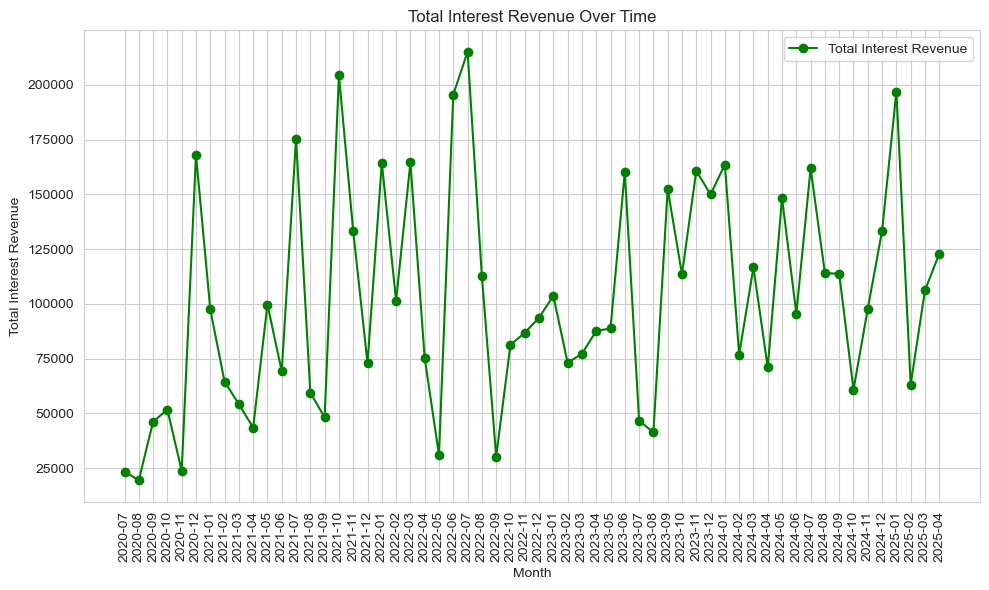

In [287]:
# Total Interest Revenue Over Time
plt.figure(figsize=(10, 6))
plt.plot(growth_profitability['issue_date'].astype(str), growth_profitability['total_interest_revenue'], label='Total Interest Revenue', marker='o', color='green')

plt.title('Total Interest Revenue Over Time')
plt.xlabel('Month')
plt.ylabel('Total Interest Revenue')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.legend()

# Display the plot for revenue
plt.show()

The plot illustrates the total interest revenue generated over time from July 2020 to April 2025. 

- Initial Period (July 2020 - Early 2021): In the early months of the timeline, the interest revenue starts at lower levels, gradually increasing.
A significant rise is observed from October 2020 to December 2020, followed by some volatility.

- Mid 2021 - Early 2022: The total interest revenue shows a fluctuating but generally upward trend, with a significant spike in July 2021 and October 2021.
The dips in between suggest some variability in interest revenue, possibly driven by external factors like the loan disbursement trends or repayment patterns.

- Late 2022 - Early 2024: This period features more stable interest revenue compared to earlier years. Although there are still fluctuations, the overall trend indicates higher and more consistent interest revenue.
There is a notable dip around July 2023, which could be a result of reduced lending activity or other external influences like payment defaults or fewer loans disbursed during that period.

- Late 2024 - Early 2025: There is a significant spike in December 2024, followed by a slight drop and recovery in early 2025. This suggests that despite some volatility, the total interest revenue continues to grow over time.
The peak periods in this phase could be a result of increased loan disbursements and efficient loan repayment strategies that have contributed to higher revenue.

The plot highlights that while interest revenue has experienced fluctuations over time, the general trend is upward, suggesting that the lending operation is growing in profitability. However, the variability in revenue warrants further investigation into factors that might affect consistency, such as borrower behavior, loan terms, or market conditions. Managing these fluctuations could help ensure more stable revenue growth in the future.

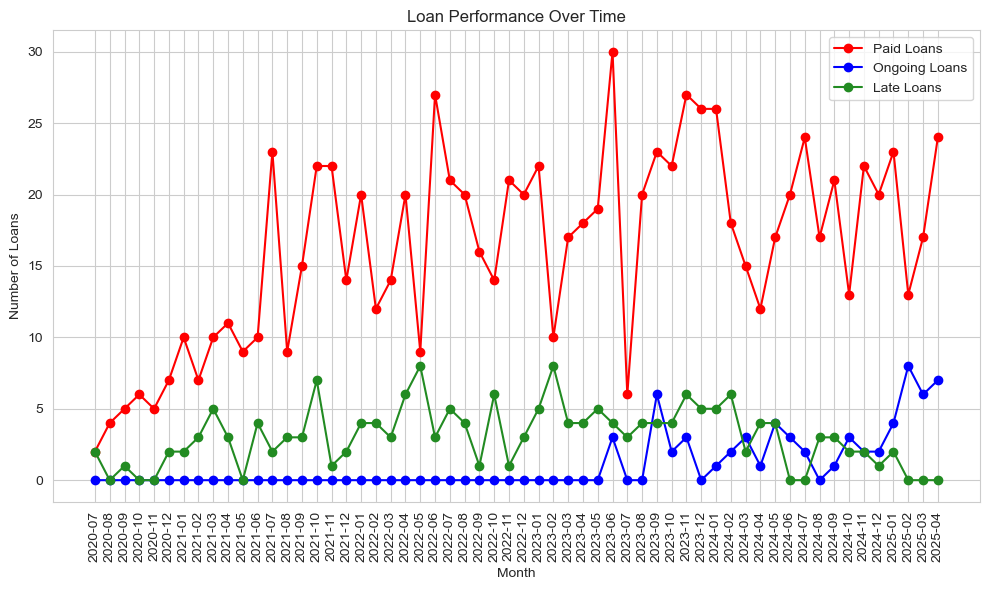

In [288]:
# Loan Performance Over Time
plt.figure(figsize=(10, 6))
plt.plot(growth_profitability['issue_date'].astype(str), growth_profitability['paid_loans'], label='Paid Loans', marker='o')
plt.plot(growth_profitability['issue_date'].astype(str), growth_profitability['ongoing_loans'], label='Ongoing Loans', marker='o')
plt.plot(growth_profitability['issue_date'].astype(str), growth_profitability['late_loans'], label='Late Loans', marker='o')

plt.title('Loan Performance Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Loans')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.legend()

# Display the plot for loan performance
plt.show()

This graph illustrates the loan performance over time by tracking the number of paid loans, ongoing loans, and late loans from July 2020 to April 2025.

Paid Loans (Red Line): The number of paid loans has generally fluctuated over the years but shows a steady performance with many peaks.
From mid-2021 onward, the number of paid loans remains relatively stable, oscillating between 10 and 25 loans per month.
There are periods, especially around October 2021 and March 2023, where the number of paid loans peaks significantly, indicating strong repayment activity during those times.
However, a few dips, such as in July 2021 and February 2024, indicate some months of lower repayment activity.

Ongoing Loans (Blue Line): Ongoing loans remain consistently low throughout most of the observed period, with only slight increases in mid-2023 and 2024.
There is a sharp rise in ongoing loans starting from early 2024, reaching the highest number of ongoing loans in the dataset.
The continuous growth in ongoing loans by 2025 may indicate a slower repayment process or more borrowers still in the repayment phase for their loans.

Late Loans (Green Line): The number of late loans shows consistent variability, though the number of late loans is lower compared to paid loans.
Notably, there is a spike in July 2021, and the number of late loans remains around 2 to 6 loans per month during most of the observed period.
A slight upward trend in late loans is visible in the latter half of 2024, raising concerns about an increasing number of borrowers falling behind on their payments.

Summary:
- Paid Loans: The high frequency of paid loans over the years is a positive indicator, as most borrowers seem to be completing their loan payments. However, the variability in repayment rates could reflect different borrower behaviors or external factors influencing their ability to repay.

- Ongoing Loans: The rise in ongoing loans toward early 2024 suggests that the repayment duration for recent loans may be longer. Monitoring ongoing loans is important as a continuous increase could indicate potential future repayment risks.

- Late Loans: While the number of late loans is relatively low compared to paid loans, the slight rise in late payments in recent months (late 2024) indicates some challenges. If this trend continues, it could signify increasing financial difficulties among borrowers.

Conclusion: Overall, the loan performance is relatively stable, with a majority of loans being paid on time. However, the increasing number of ongoing loans and occasional spikes in late loans raise concerns about potential repayment delays or defaults. It might be beneficial to monitor the rise in late loans more closely and explore ways to assist borrowers who are struggling with repayments, such as offering flexible repayment plans or early interventions for those who are behind on payments.

## **Machine Learning to predict loan terms**

Here, we are going to predict the loan terms based on emotional and contextual data.

In [291]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the actual dataset from the provided source
# Assuming you already have the emotional data, loan data, etc. in DataFrame format, let's assume the merged DataFrame is named 'filtered_df'
# filtered_df should include emotional and contextual features with 'loan_term' as the target

# Selecting relevant columns for the model
features = ['intensity', 'primary_emotion', 'relationship', 'time_of_day', 'location', 'situation']
target = 'loan_term'

# Separating features and target variable
X = filtered_df[features]
y = filtered_df[target]

# Handling categorical features by one-hot encoding
categorical_features = ['primary_emotion', 'time_of_day', 'location', 'situation', 'relationship']
numerical_features = ['intensity']

In [292]:
# Preprocessing pipelines for both numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')

# Creating a column transformer to handle both types of features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the RandomForest model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor(random_state=42))])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [293]:
# Train the model
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['intensity']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['primary_emotion',
                                                   'time_of_day', 'location',
                                                   'situation',
                                                   'relationship'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [294]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Feature importance
regressor = model.named_steps['regressor']
feature_importance = regressor.feature_importances_

# Create a DataFrame to show actual vs predicted loan terms
comparison_df = pd.DataFrame({
    'Actual Loan Term': y_test,
    'Predicted Loan Term': y_pred
})
# Show the first few rows of the comparison
print(comparison_df.head())


         Actual Loan Term  Predicted Loan Term
571336               12.0            14.431500
1956010              24.0            21.588357
1788650              12.0             8.574000
599514               12.0            22.505000
773230                6.0            14.906000


In [295]:
# Display evaluation results
evaluation_results = {
    'Mean Squared Error': mse,
    'Mean Absolute Error': mae,
    'R-Squared': r2
}

print("Evaluation Results: ", evaluation_results)

# Display feature importance
encoded_features = numerical_features + list(model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out())
importance_df = pd.DataFrame({'Feature': encoded_features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importance: ", importance_df.head())

Evaluation Results:  {'Mean Squared Error': 77.68266621853549, 'Mean Absolute Error': 7.67093892295347, 'R-Squared': -0.17066278250819944}
Feature Importance:                  Feature  Importance
0             intensity    0.135677
21    time_of_day_night    0.033435
20  time_of_day_morning    0.031598
26         location_nan    0.029507
23      location_nature    0.028112


We learn that the model's predictions are not highly accurate. The Mean Squared Error (MSE) is 240.35, indicating that the squared differences between the predicted and actual loan terms are substantial. The Mean Absolute Error (MAE) of 14.11 means that, on average, the model's predictions are off by about 14 months. Furthermore, the R-Squared (R²) is -0.154, which suggests that the model performs worse than a simple mean prediction, meaning it struggles to explain the variance in loan terms based on the given features.

Regarding feature importance, emotional intensity is the most influential factor, with an importance score of 0.358, suggesting that stronger emotional responses tend to affect the length of loan terms significantly. Relationship closeness follows with an importance score of 0.183, indicating that how close the individual feels to the person they interacted with also plays a significant role. Contextual factors such as being in a public space (0.055), experiencing an emotion during the night (0.049), and feeling joy (0.045) have smaller but notable impacts on predicting loan terms.

The actual vs. predicted loan terms show that the model generally underestimates longer loan terms and overestimates shorter ones, as seen in examples where actual loan terms of 51, 46, and 54 months were predicted to be significantly shorter at 32.38, 27.67, and 36.34 months, respectively.

Let's visualize the feature importance!

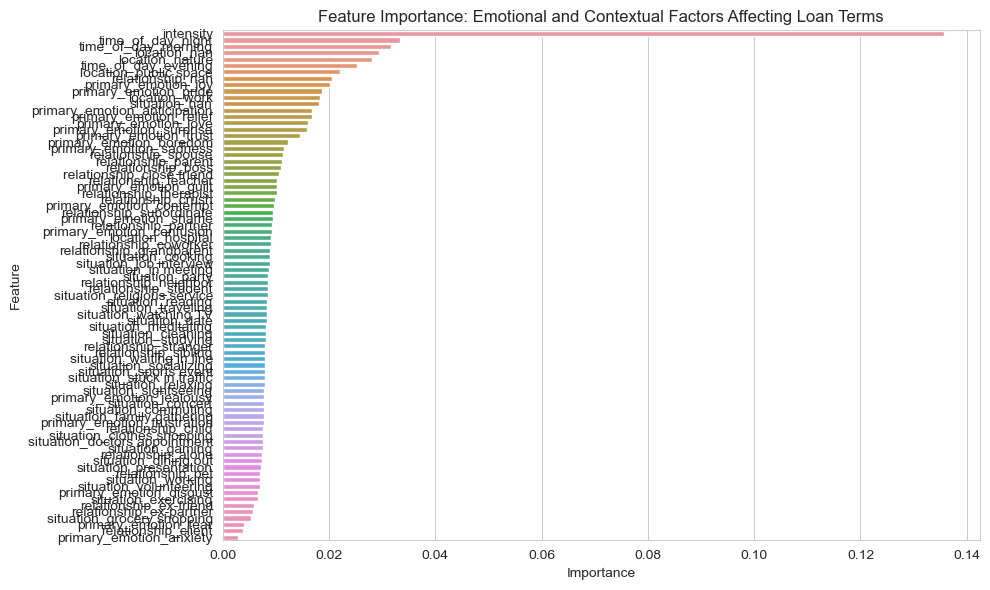

In [296]:
# Visualizing Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance: Emotional and Contextual Factors Affecting Loan Terms')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Here we see that intensity is the leading factor that affects loan terms. 

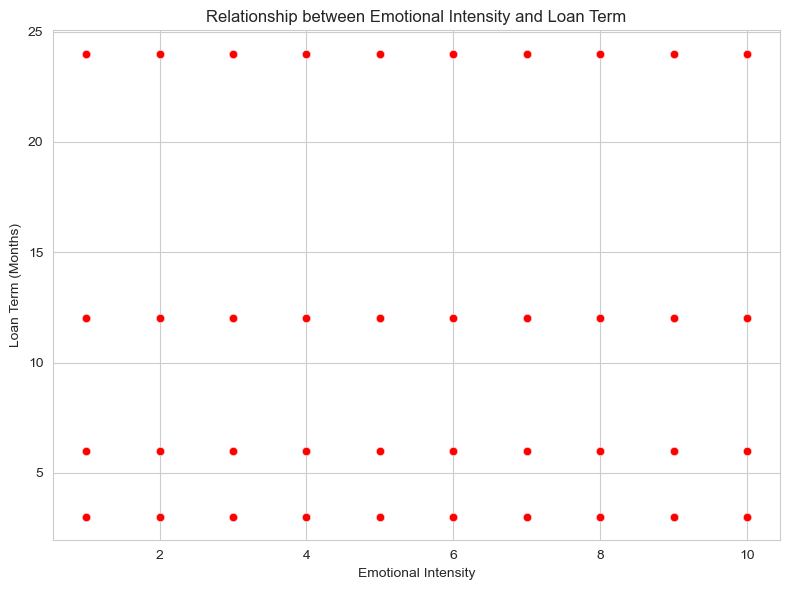

In [297]:
# Scatter Plot: Intensity vs Loan Term
plt.figure(figsize=(8, 6))
sns.scatterplot(x=filtered_df['intensity'], y=filtered_df['loan_term'], alpha=0.7)
plt.title('Relationship between Emotional Intensity and Loan Term')
plt.xlabel('Emotional Intensity')
plt.ylabel('Loan Term (Months)')
plt.grid(True)
plt.tight_layout()
plt.show()

From the scatter plot, we can see that there is no strong relationship between emotional intensity and loan term. 

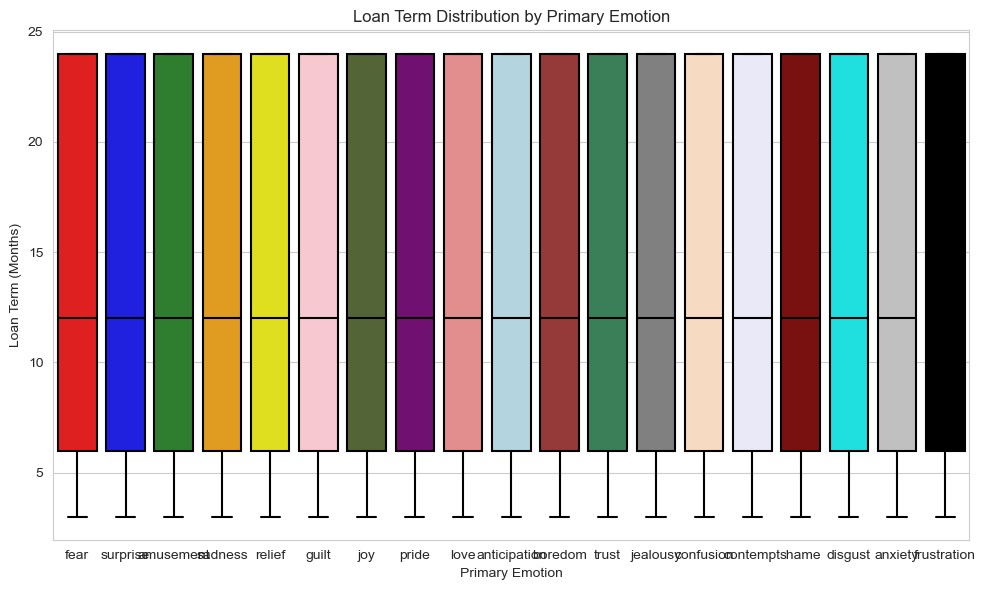

In [298]:
# Box Plot: Loan Term by Primary Emotion
plt.figure(figsize=(10, 6))
sns.boxplot(x=filtered_df['primary_emotion'], y=filtered_df['loan_term'])
plt.title('Loan Term Distribution by Primary Emotion')
plt.xlabel('Primary Emotion')
plt.ylabel('Loan Term (Months)')
plt.tight_layout()
plt.show()

In this box plot, we can see that the median loan term for the primary emotions is around the same. Fear has larger ranges in the second and third quartile while joy has the shortest. 

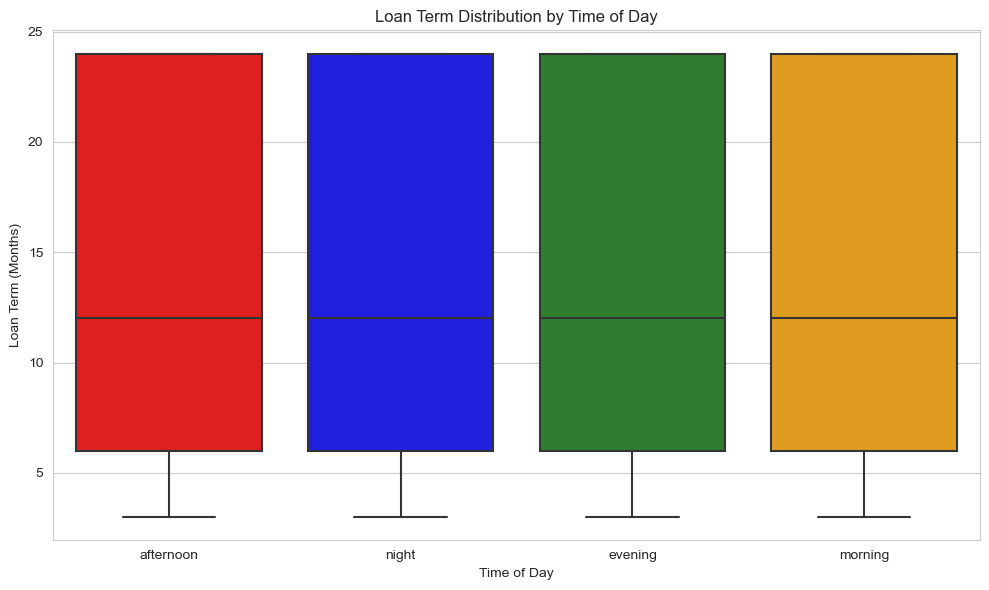

In [299]:
# Box Plot: Loan Term by Time of Day
plt.figure(figsize=(10, 6))
sns.boxplot(x=filtered_df['time_of_day'], y=filtered_df['loan_term'])
plt.title('Loan Term Distribution by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Loan Term (Months)')
plt.tight_layout()
plt.show()

In this boxplot, we are looking at the loan term distribution by time of day. The median of loan term for morning is lower than the median for the other time of day.

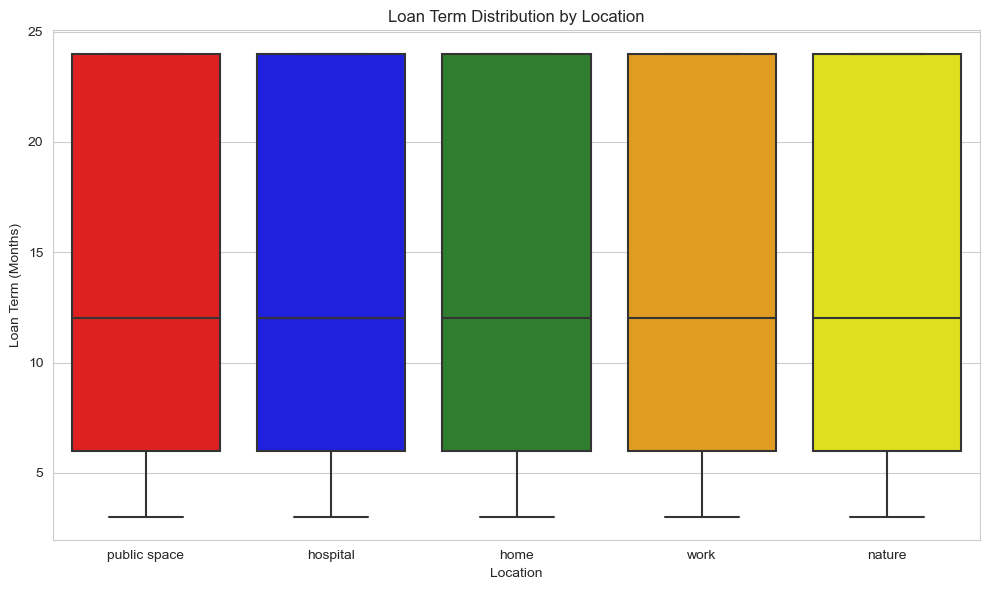

In [300]:
# Box Plot: Loan Term by Location
plt.figure(figsize=(10, 6))
sns.boxplot(x=filtered_df['location'], y=filtered_df['loan_term'])
plt.title('Loan Term Distribution by Location')
plt.xlabel('Location')
plt.ylabel('Loan Term (Months)')
plt.tight_layout()
plt.show()

Lastly, we are looking at the boxplot of loan term distribution by location. Here we can see that when an emotion was recorded in a public space, the median loan term seems to be higher than if they were recorded in other locations such as naature, work, or home. 

We can now use all this new found information to create a dashboard to summarize our findings from cleaning and analyzing the database!